# The effects of Partial and Complete Lockdowns in decreasing the number of cases
The World Health Organisation (WHO), along with John Hopkins University (JHU) collects data related to COVID-19 and provide insights in the form of dashboard. The target of this Project task is to analyze data from various sources and explore how the number of cases are increasing in different nations. There are 2 main datasets are used in this project: Daily COVID-19 cases worldwide dataset from [Our World in Data](https://ourworldindata.org/covid-cases) and COVID-19 Goverment measures dataset from [ACAPS](https://www.acaps.org/covid-19-government-measures-dataset). Metadata for COVID-19 Goverment measures dataset is showed in [HDX](https://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba). 

## Metadata for Daily COVID-19 cases worldwide dataset

* __DATE_IMPLEMENTED__ the date recorded daily from January 2020 to October 2021
* __COUNTRY__ the country name 
* __total_cases__ the cumulative sum of new cases recorded daily
* __new_cases__ the number of COVID-19 positive cases recored daily

## Sample Selection
The sample of 10 countries that both have Partial Lockdown and Full Lockdown would be used in the project. 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import math
import copy
#import pingouin as pg
#import janitor as jn
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
%matplotlib inline
# prediction
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
import prophet
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Importing plotly failed. Interactive plots will not work.


### Data Preparation and Data Cleaning

**Read data COVID-19 Goverment measures dataset from [ACAPS](https://www.acaps.org/covid-19-government-measures-dataset)**

In [2]:
# Read the COVID-19 Goverment measures dataset which contains data for lockdown period
ld = pd.read_csv("files/acaps_covid19_government_measures_dataset_0.csv")
ld.head()

ID  ISO      COUNTRY REGION ADMIN_LEVEL_NAME  PCODE  \
0  4245  AFG  Afghanistan   Asia              NaN    NaN   
1  4246  AFG  Afghanistan   Asia              NaN    NaN   
2  4247  AFG  Afghanistan   Asia              NaN    NaN   
3  4248  AFG  Afghanistan   Asia              NaN    NaN   
4    23  AFG  Afghanistan   Asia              NaN    NaN   

                               LOG_TYPE                CATEGORY  \
0  Introduction / extension of measures  Public health measures   
1  Introduction / extension of measures  Public health measures   
2  Introduction / extension of measures   Movement restrictions   
3  Introduction / extension of measures  Public health measures   
4  Introduction / extension of measures   Movement restrictions   

                                             MEASURE TARGETED_POP_GROUP  \
0                                Awareness campaigns                NaN   
1  Health screenings in airports and border cross...            checked   
2                   International flights suspension            checked   
3  Health screenings in airports and border cross...                NaN   
4                                      Border checks            checked   

                                            COMMENTS NON_COMPLIANCE  \
0  MoPH begins announcements on their facebook to...            NaN   
1  Health teams at airports will check passengers...            NaN   
2                   Flights to China are suspended.             NaN   
3  Health screenings of all passengers at airports.             NaN   
4                       All China and Iran nationals            NaN   

  DATE_IMPLEMENTED            SOURCE SOURCE_TYPE  \
0          24/1/20  Afghanistan MoPH  Government   
1          26/1/20  Afghanistan MoPH  Government   
2          27/1/20  Afghanistan MoPH  Government   
3          27/1/20  Afghanistan MoPH  Government   
4           1/2/20       US Embassy   Government   

                                                LINK ENTRY_DATE  \
0  https://www.facebook.com/af.moph/posts/1005130...     7/4/20   
1  https://www.facebook.com/af.moph/posts/1006458...     7/4/20   
2  https://www.facebook.com/af.moph/photos/a.4625...     7/4/20   
3  https://www.facebook.com/af.moph/photos/a.4625...     7/4/20   
4     https://af.usembassy.gov/covid-19-information/    14/3/20   

  Alternative source  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

**Drop unnecessary columns**

In [3]:
#Drop unnecessary columns
ld=ld.drop(['ID', 'ISO', 'PCODE', 'ADMIN_LEVEL_NAME', 'TARGETED_POP_GROUP', 'Alternative source', 'LINK', 'NON_COMPLIANCE', 'ENTRY_DATE', 'SOURCE', 'LOG_TYPE', 'CATEGORY', 'COMMENTS', 'SOURCE_TYPE'], axis=1)

**Change data in column 'DATE_IMPLEMENTED' from type integer to datetime**

In [4]:
#Change data type of column 'DATE_IMPLEMENTED' to datetime
ld['DATE_IMPLEMENTED'] = pd.to_datetime(ld['DATE_IMPLEMENTED'])
ld.head()

COUNTRY REGION                                            MEASURE  \
0  Afghanistan   Asia                                Awareness campaigns   
1  Afghanistan   Asia  Health screenings in airports and border cross...   
2  Afghanistan   Asia                   International flights suspension   
3  Afghanistan   Asia  Health screenings in airports and border cross...   
4  Afghanistan   Asia                                      Border checks   

  DATE_IMPLEMENTED  
0       2020-01-24  
1       2020-01-26  
2       2020-01-27  
3       2020-01-27  
4       2020-01-02

**Select 10 countries that applied both Partial Lockdown and Full Lockdown in the dataset to do the analysis**

In [5]:
#Filter data with Lockdown measure and 10 countries that have both Partial Lockdown and Full Lockdown
ld=ld[ld['MEASURE'].isin(['Full lockdown', 'Partial lockdown'])]
ld=ld[ld['COUNTRY'].isin(['Austria', 'Iraq', 'Israel', 'Italy', 'Jordan', 'Kazakhstan', 'Malaysia', 'Nepal', 'Philippines', 'Spain'])]
ld.head()

COUNTRY  REGION           MEASURE DATE_IMPLEMENTED
1445  Austria  Europe  Partial lockdown       2020-03-16
1461  Austria  Europe  Partial lockdown       2020-03-19
1495  Austria  Europe  Partial lockdown       2020-07-04
1668  Austria  Europe  Partial lockdown       2020-03-11
1681  Austria  Europe     Full lockdown       2020-08-11

**Fill Data for Joining Daily COVID-19 cases worldwide dataset**
* Since the COVID-19 Goverment measures dataset only provides the date that the lockdown period started, it could not showed the whole period of lockdown and will not match the Daily COVID-19 cases worldwide dataset which is recorded daily. 
* I have to fill data to COVID-19 Goverment measures dataset and transform it the daily recorded data for lockdown period.
* First, data is sorted in ascending order and reset index to the value in column 'DATE_IMPLEMENTED'. Next, I will loop though each country and make separate daily recorded dataframe for each country. Finally, all dataframes will be added to one dataframe.

In [6]:
#Set index by column'DATE_IMPLEMENTED'
def reset_idx(df, col):
    df.sort_values(by=col, inplace=True) #sort date by ascending order
    df.set_index(col, inplace=True) #reset index
    return df
df_list=[] #Create a list containing daily data of lockdown period of each country sample
for i in ld['COUNTRY'].unique(): #Loop through every country to make daily range for lockdown period for each country
    df=ld[ld['COUNTRY']==i]
    reset_idx(df, 'DATE_IMPLEMENTED') #Call reset_idx funcion above
    idx = pd.date_range(start=df.index.min(), end=df.index.max()) #create daily range for lockdown period
    df.index = pd.DatetimeIndex(df.index)
    idx_non_dup = np.unique( df.index.values, return_index = True )[1] #Only keep unique value and remove duplicate value
    df = df.iloc[idx_non_dup] #Add unique value to dataframe 
    df = df.reindex(idx) #change index to daily data
    df.ffill(inplace=True) #Fill missing value by previous row values
    df['DATE_IMPLEMENTED']=pd.DatetimeIndex(df.index) #Create the new column 'DATE_IMPLEMENTED' that shows daily data for period lockdown
    df_list.append(df) #Add all adjusted dataframe of all countries to df_list
df_list
#Add all country dataframe together
ld_join=df_list[0].append(df_list[1:]) #Add all data together and make the whole dataframe 
ld_join

COUNTRY  REGION           MEASURE DATE_IMPLEMENTED
2020-03-11  Austria  Europe  Partial lockdown       2020-03-11
2020-03-12  Austria  Europe  Partial lockdown       2020-03-12
2020-03-13  Austria  Europe  Partial lockdown       2020-03-13
2020-03-14  Austria  Europe  Partial lockdown       2020-03-14
2020-03-15  Austria  Europe  Partial lockdown       2020-03-15
...             ...     ...               ...              ...
2020-11-01    Spain  Europe  Partial lockdown       2020-11-01
2020-11-02    Spain  Europe  Partial lockdown       2020-11-02
2020-11-03    Spain  Europe  Partial lockdown       2020-11-03
2020-11-04    Spain  Europe  Partial lockdown       2020-11-04
2020-11-05    Spain  Europe     Full lockdown       2020-11-05

[2655 rows x 4 columns]

**Read the Daily COVID-19 cases worldwide dataset**

In [7]:
# Read the Daily COVID-19 cases worldwide dataset which contains cases recorded daily 
tc_raw = pd.read_csv("files/owid-covid-data.csv")
tc_raw.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   female_smokers  male_smokers  handwashing_facilities  \
0             NaN           NaN                  37.746   
1             NaN           NaN                  37.746   
2             NaN           NaN                  37.746   
3             NaN           NaN                  37.746   
4             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  \
0                         0.5            64.83                    0.511   
1                         0.5            64.83                    0.511   
2                         0.5            64.83                    0.511   
3                         0.5            64.83                    0.511   
4                         0.5            64.83                    0.511   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 65 columns]

**Create new dataframe with necessary columns include 10 selected countries**

In [8]:
#Create new dataframe with necessary columns and select 10 countries as same as the COVID-19 Goverment measures dataframe
df = [tc_raw['date'], tc_raw['location'], tc_raw['total_cases'], tc_raw['new_cases'], tc_raw['continent']]
headers = ['DATE_IMPLEMENTED', 'COUNTRY', 'total_cases', 'new_cases', 'REGION'] #Change headers as same as ld_join
tc = pd.concat(df, axis=1, keys=headers) 
tc=tc[tc['COUNTRY'].isin(['Austria', 'Iraq', 'Israel', 'Italy', 'Jordan', 'Kazakhstan', 'Malaysia', 'Nepal', 'Philippines', 'Spain'])]
tc['DATE_IMPLEMENTED'] = tc['DATE_IMPLEMENTED'].apply(pd.to_datetime)
tc.head()

DATE_IMPLEMENTED  COUNTRY  total_cases  new_cases  REGION
7230       2020-02-25  Austria          2.0        2.0  Europe
7231       2020-02-26  Austria          2.0        0.0  Europe
7232       2020-02-27  Austria          3.0        1.0  Europe
7233       2020-02-28  Austria          3.0        0.0  Europe
7234       2020-02-29  Austria          9.0        6.0  Europe

**Merge 2 dataframe ld_join (daily data for applied lockdown period) and tc (daily cases recorded)**

In [9]:
#Merge 2 dataframe ld_join (daily data for applied lockdown period) and tc (daily cases recorded) by country and date applied lockdown measurement
ld_tc = tc.merge(ld_join, left_on=['DATE_IMPLEMENTED','COUNTRY'], right_on=['DATE_IMPLEMENTED','COUNTRY'], how='left')

**Drop uneccessary column and fill missing 'MEASURE' data with 'Non-Lockdown'**

In [10]:
#Drop uneccessary column and fill missing 'MEASURE' data with 'Non-Lockdown'
ld_tc=ld_tc.drop(['REGION_y'], axis=1)
ld_tc['MEASURE']=ld_tc['MEASURE'].fillna('Non-Lockdown')
ld_tc.head()

DATE_IMPLEMENTED  COUNTRY  total_cases  new_cases REGION_x       MEASURE
0       2020-02-25  Austria          2.0        2.0   Europe  Non-Lockdown
1       2020-02-26  Austria          2.0        0.0   Europe  Non-Lockdown
2       2020-02-27  Austria          3.0        1.0   Europe  Non-Lockdown
3       2020-02-28  Austria          3.0        0.0   Europe  Non-Lockdown
4       2020-02-29  Austria          9.0        6.0   Europe  Non-Lockdown

**Number of days by COUNTRY and MEASURE**

In [11]:
# Number of days by COUNTRY and MEASURE
ld_group = ld_tc.groupby(['COUNTRY','MEASURE']) #Group data by COUNTRY and MEASURE
ld_vs_country=pd.DataFrame({'Days_number':ld_group.size()}) #Number of days that applied different measurements of each country
ld_vs_country

Days_number
COUNTRY     MEASURE                      
Austria     Full lockdown              99
            Non-Lockdown              356
            Partial lockdown          153
Iraq        Full lockdown              24
            Non-Lockdown              368
            Partial lockdown          217
Israel      Full lockdown              68
            Non-Lockdown              356
            Partial lockdown          189
Italy       Full lockdown             123
            Non-Lockdown              403
            Partial lockdown          107
Jordan      Full lockdown              55
            Non-Lockdown              384
            Partial lockdown          162
Kazakhstan  Full lockdown              72
            Non-Lockdown              358
            Partial lockdown          161
Malaysia    Full lockdown             173
            Non-Lockdown              385
            Partial lockdown           82
Nepal       Full lockdown              40
            Non-Lockdown              353
            Partial lockdown          246
Philippines Full lockdown              44
            Non-Lockdown              319
            Partial lockdown          271
Spain       Full lockdown             168
            Non-Lockdown              353
            Partial lockdown          111

In [12]:
set(ld_tc['REGION_x'])

{'Asia', 'Europe'}

In [13]:
ld_tc[['total_cases', 'new_cases']] = ld_tc[['total_cases','new_cases']].fillna(value=0)
ld_tc.isna().sum()

DATE_IMPLEMENTED    0
COUNTRY             0
total_cases         0
new_cases           0
REGION_x            0
MEASURE             0
dtype: int64

### Detect and remove outliers in column 'new_cases' and 'total_cases'

Text(0.5, 1.0, 'The boxplot of new cases between countries after executing full and partial lockdown')

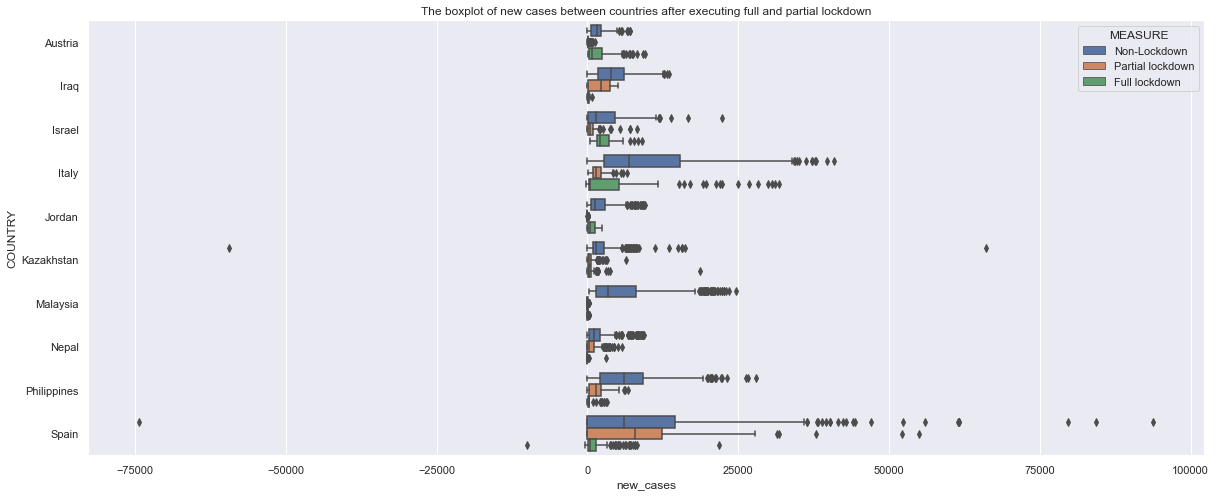

In [14]:
# Outlier of the dataset
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot('new_cases','COUNTRY', hue = 'MEASURE', data = ld_tc)
plt.title("The boxplot of new cases between countries after executing full and partial lockdown")

The boxplot above shows the effectiveness of executing Full and Partial Lockdown for managing the increase in Covid_19 cases in each country. In general, the difference in the number of new cases between Full and Partial Lockdown implementation seems to not to be normally distributed. The medians show that Full Lockdown implementation in Spain, Phillipines, Nepal, Kazakhstan, Iraq is more effective than Partial Lockdown one. However, there are some countries which are Jordan, Italy, Isreal and Austria show that implementing Partial Lockdown is more effective than Full Lockdown Implementation.

In addition, there is exist one outlier (-10,000) and this outlier only presents in the new_cases column. To improve the quality of the analysis, we will detect and remove the value of -10,000 in the new_cases column. 

In [15]:
# Detect outliers function
def outliers (df, var):
    Q1=df[var].quantile(0.25)
    Q3=df[var].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-(1.5*IQR)
    upper_bound=Q3+(3*IQR)
    outlier=df.index[(df[var]<lower_bound) | (df[var]>upper_bound)]
    return outlier
# List store outliers 
outlier_list=[]
def outlier_detect (df, var):
    for i in df[var]:
        outlier_list.extend(outliers(df, var))
# Remove outliers
def rev(df, outlier):
    outlier=sorted(set(outlier))
    df=df.drop(outlier)
    return df
#Clean data for ld_tc_trial 
outlier_detect(ld_tc,'new_cases')
ld_tc_trial=rev(ld_tc,outlier_list)

outlier_list=[]
outlier_detect(ld_tc,'new_cases')
ld_tc_trial=rev(ld_tc,outlier_list)

outlier_list=[]
outlier_detect(ld_tc,'total_cases')
ld_tc_trial=rev(ld_tc,outlier_list)

<AxesSubplot:xlabel='new_cases', ylabel='COUNTRY'>

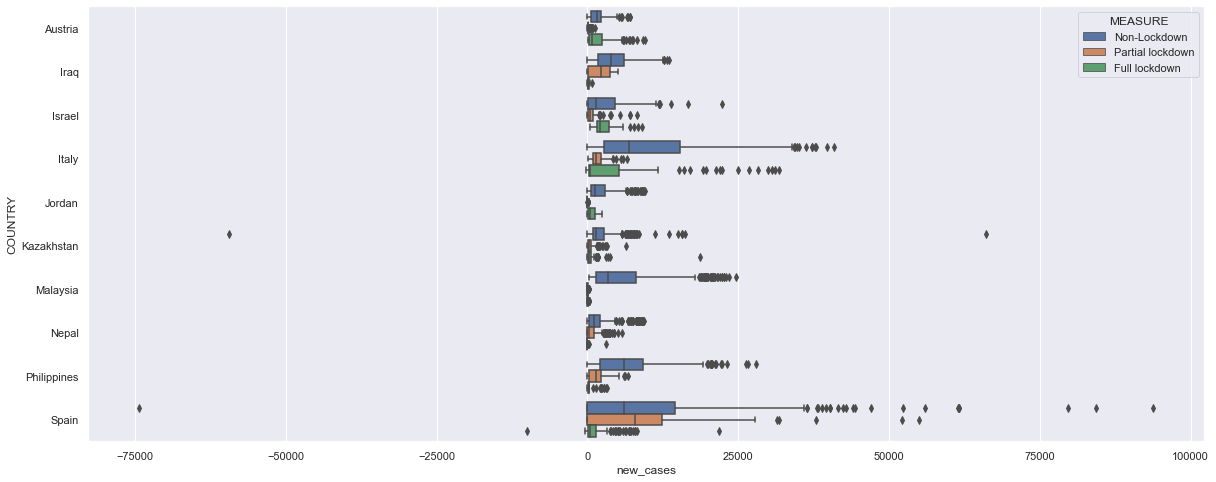

In [16]:
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot('new_cases','COUNTRY', hue = 'MEASURE', data = ld_tc)

In [17]:
# Trial
ld_tc_trial = ld_tc[ld_tc['MEASURE'].isin(['Partial lockdown','Full lockdown'])]
ld_tc_trial.head()

DATE_IMPLEMENTED  COUNTRY  total_cases  new_cases REGION_x  \
15       2020-03-11  Austria        246.0       64.0   Europe   
16       2020-03-12  Austria        302.0       56.0   Europe   
17       2020-03-13  Austria        504.0      202.0   Europe   
18       2020-03-14  Austria        655.0      151.0   Europe   
19       2020-03-15  Austria        860.0      205.0   Europe   

             MEASURE  
15  Partial lockdown  
16  Partial lockdown  
17  Partial lockdown  
18  Partial lockdown  
19  Partial lockdown

## Data Visualizing
### Europe

In [18]:
#Sorting out data by region
ld_tc_EU = ld_tc_trial[(ld_tc_trial['REGION_x']=='Europe')] 
ld_tc_EU.head()

DATE_IMPLEMENTED  COUNTRY  total_cases  new_cases REGION_x  \
15       2020-03-11  Austria        246.0       64.0   Europe   
16       2020-03-12  Austria        302.0       56.0   Europe   
17       2020-03-13  Austria        504.0      202.0   Europe   
18       2020-03-14  Austria        655.0      151.0   Europe   
19       2020-03-15  Austria        860.0      205.0   Europe   

             MEASURE  
15  Partial lockdown  
16  Partial lockdown  
17  Partial lockdown  
18  Partial lockdown  
19  Partial lockdown

In [19]:
# Summary Dataset
ld_tc_EU.describe()

total_cases     new_cases
count  7.610000e+02    761.000000
mean   2.140238e+05   2983.013141
std    2.383351e+05   6146.103022
min    1.000000e+00 -10034.000000
25%    2.095500e+04    124.000000
50%    2.094650e+05    543.000000
75%    2.566190e+05   2835.000000
max    1.306316e+06  55019.000000

<AxesSubplot:xlabel='COUNTRY', ylabel='MEASURE'>

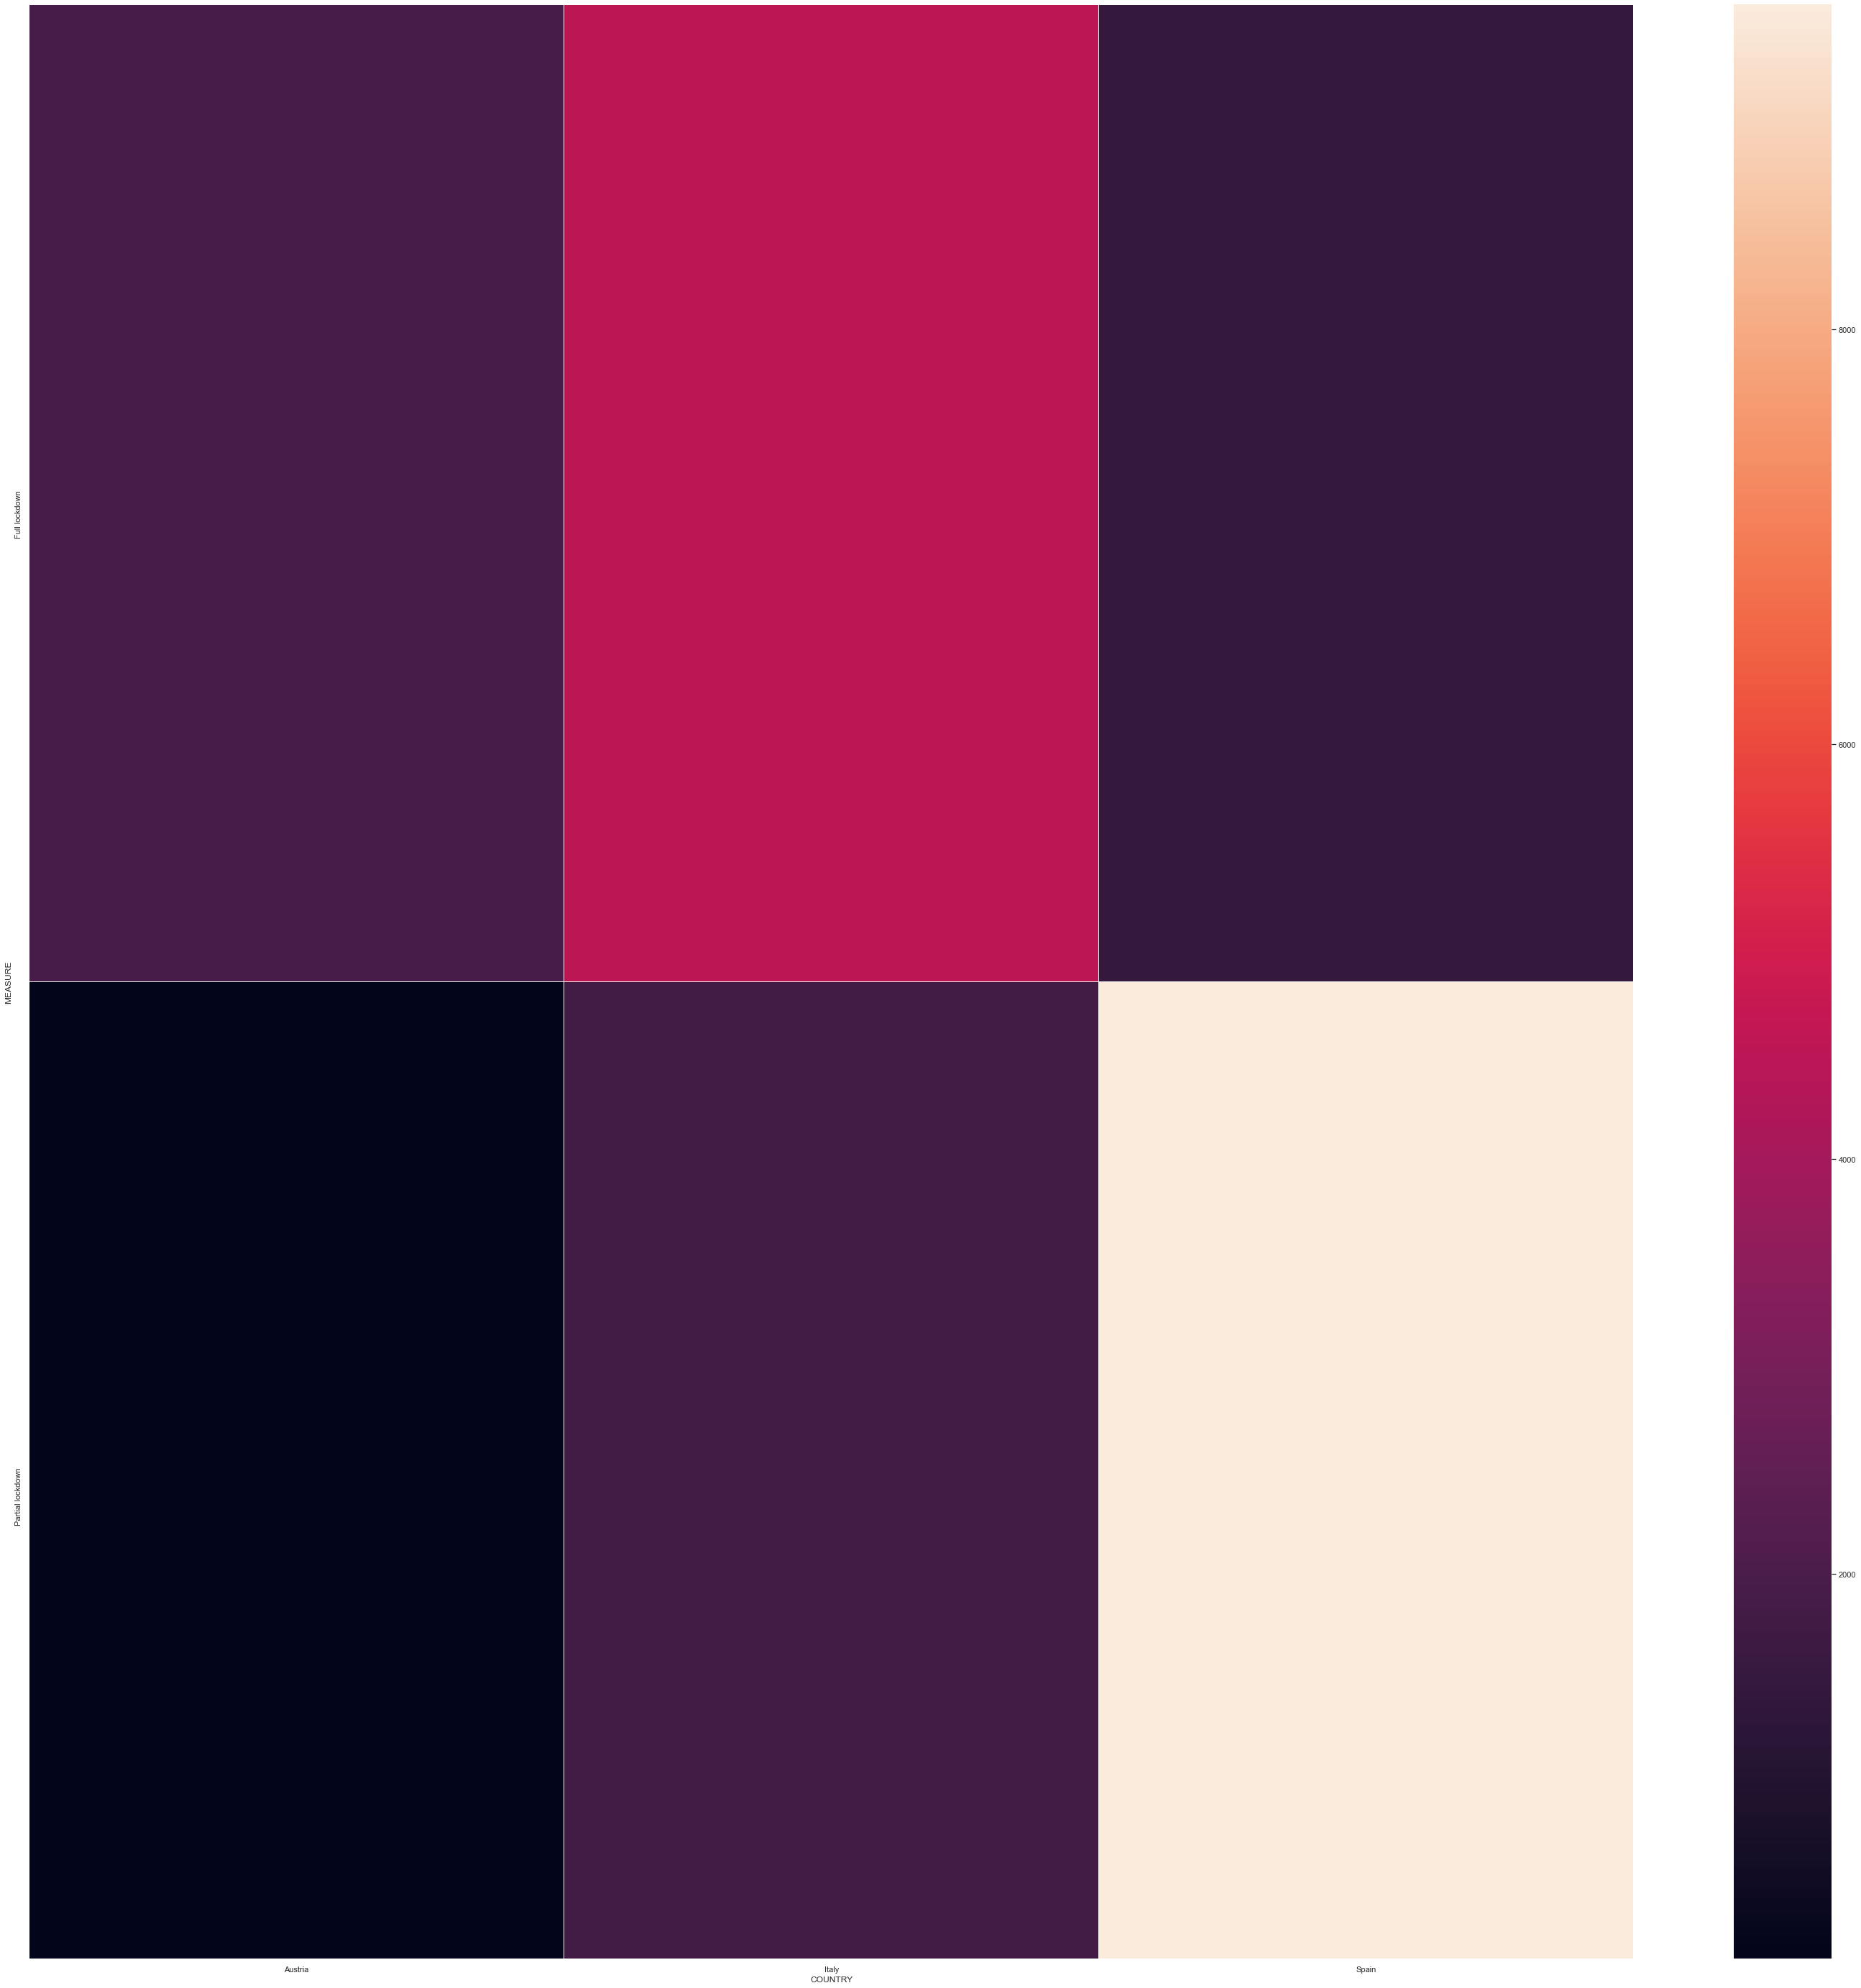

In [20]:
ld_tc_pv=ld_tc_EU.pivot_table(index='MEASURE', columns='COUNTRY', values = 'new_cases')
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(ld_tc_pv,linewidths=.5)

### Austria

In [21]:
ld_tc_EU_Austria = ld_tc_EU[ld_tc_EU['COUNTRY'].isin(['Austria'])]

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

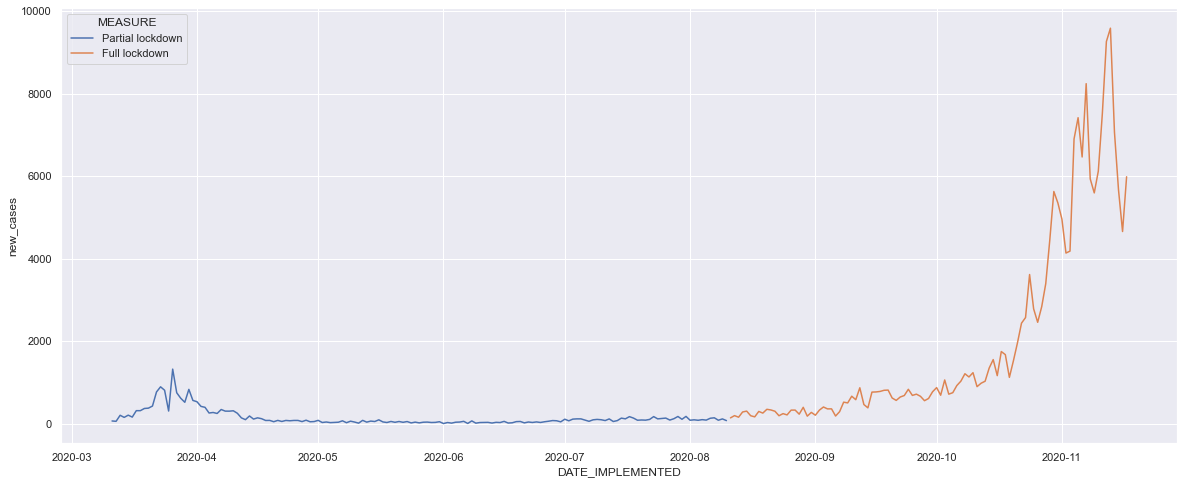

In [22]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_EU_Austria)

In [23]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_EU_Austria)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

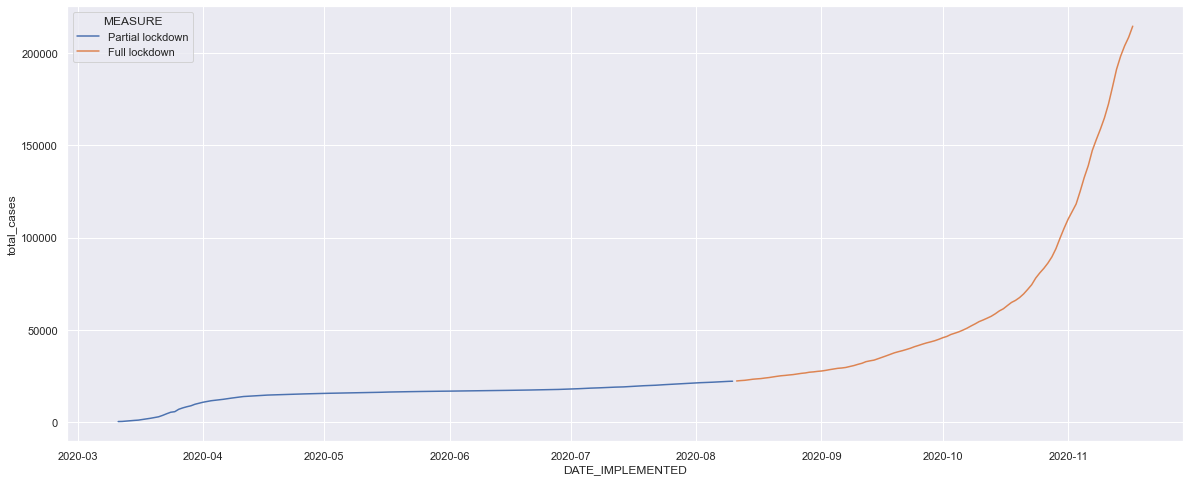

In [24]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_EU_Austria)

### Italy

In [25]:
ld_tc_EU_Italy = ld_tc_EU[ld_tc_EU['COUNTRY'].isin(['Italy'])]

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

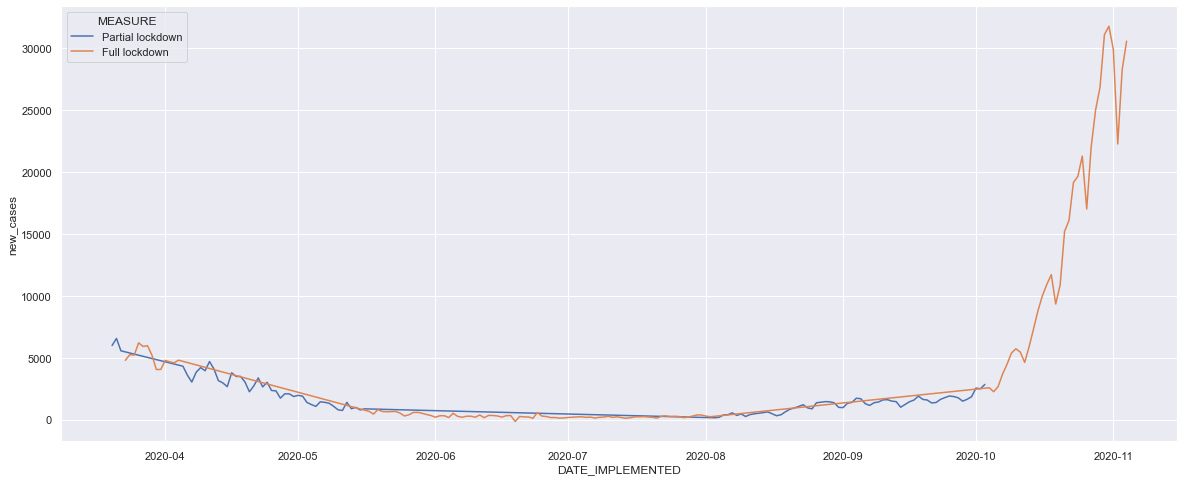

In [26]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_EU_Italy)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

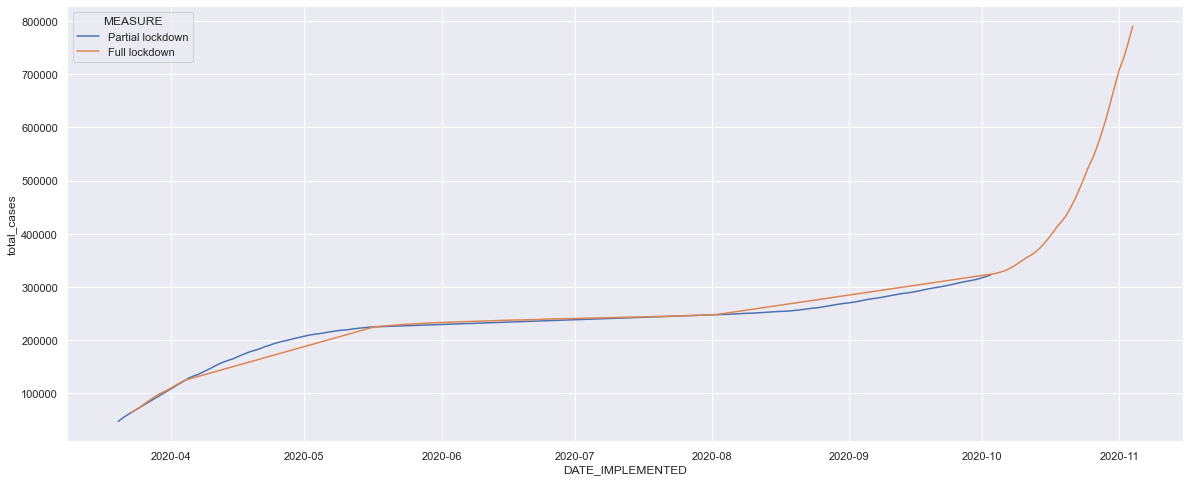

In [27]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_EU_Italy)

In [28]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_EU_Italy)

### Spain

In [29]:
ld_tc_EU_Spain = ld_tc_EU[ld_tc_EU['COUNTRY'].isin(['Spain'])]

In [30]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_EU_Spain)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

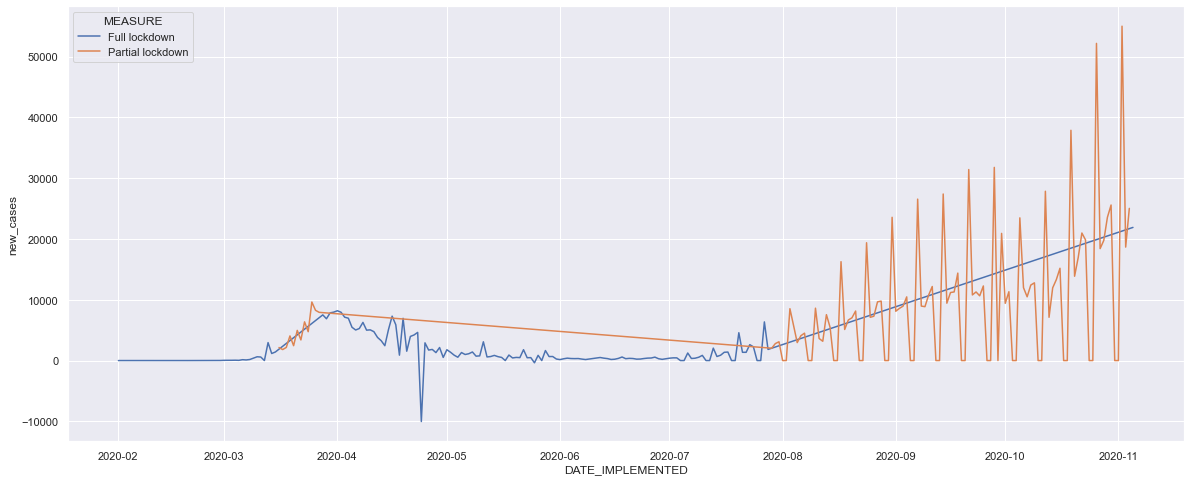

In [31]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_EU_Spain)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

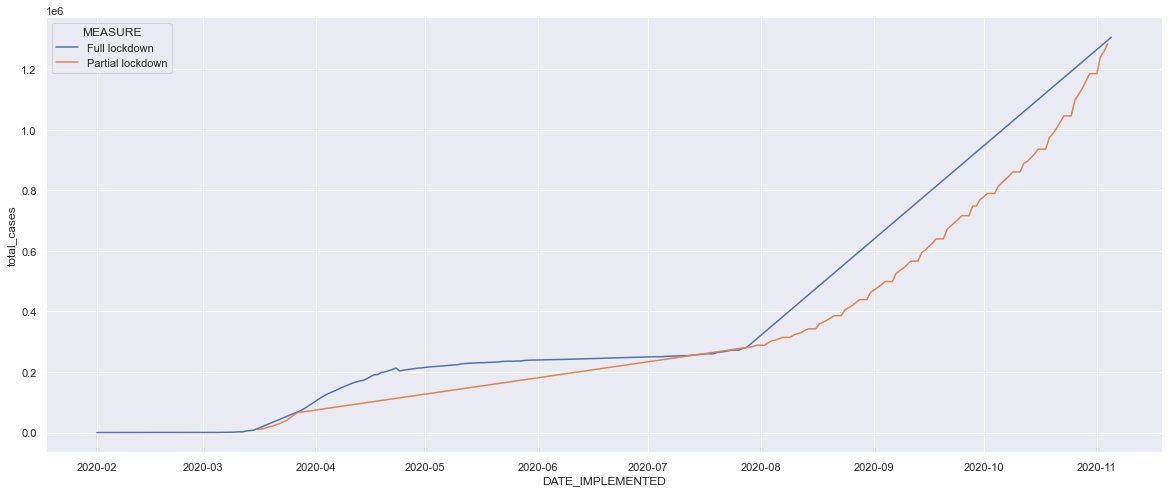

In [32]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_EU_Spain)

## Asia

In [33]:
ld_tc_AS = ld_tc_trial[(ld_tc_trial['REGION_x']=='Asia')] 
ld_tc_AS = ld_tc_AS[(ld_tc_AS['MEASURE']== 'Full lockdown')|(ld_tc_AS['MEASURE']== 'Partial lockdown')]
ld_tc_AS.head()

DATE_IMPLEMENTED COUNTRY  total_cases  new_cases REGION_x  \
621       2020-03-08    Iraq         60.0        6.0     Asia   
622       2020-03-09    Iraq         60.0        0.0     Asia   
623       2020-03-10    Iraq         71.0       11.0     Asia   
624       2020-03-11    Iraq         71.0        0.0     Asia   
625       2020-03-12    Iraq         71.0        0.0     Asia   

              MEASURE  
621  Partial lockdown  
622  Partial lockdown  
623  Partial lockdown  
624  Partial lockdown  
625  Partial lockdown

In [34]:
# Summary dataset
ld_tc_AS.describe()

total_cases     new_cases
count    1804.000000   1804.000000
mean    73069.335366    916.778271
std    115713.014158   1409.380971
min         0.000000   -110.000000
25%      1235.750000     17.000000
50%     11798.000000    215.000000
75%    102953.250000   1396.750000
max    482296.000000  18757.000000

<AxesSubplot:xlabel='COUNTRY', ylabel='MEASURE'>

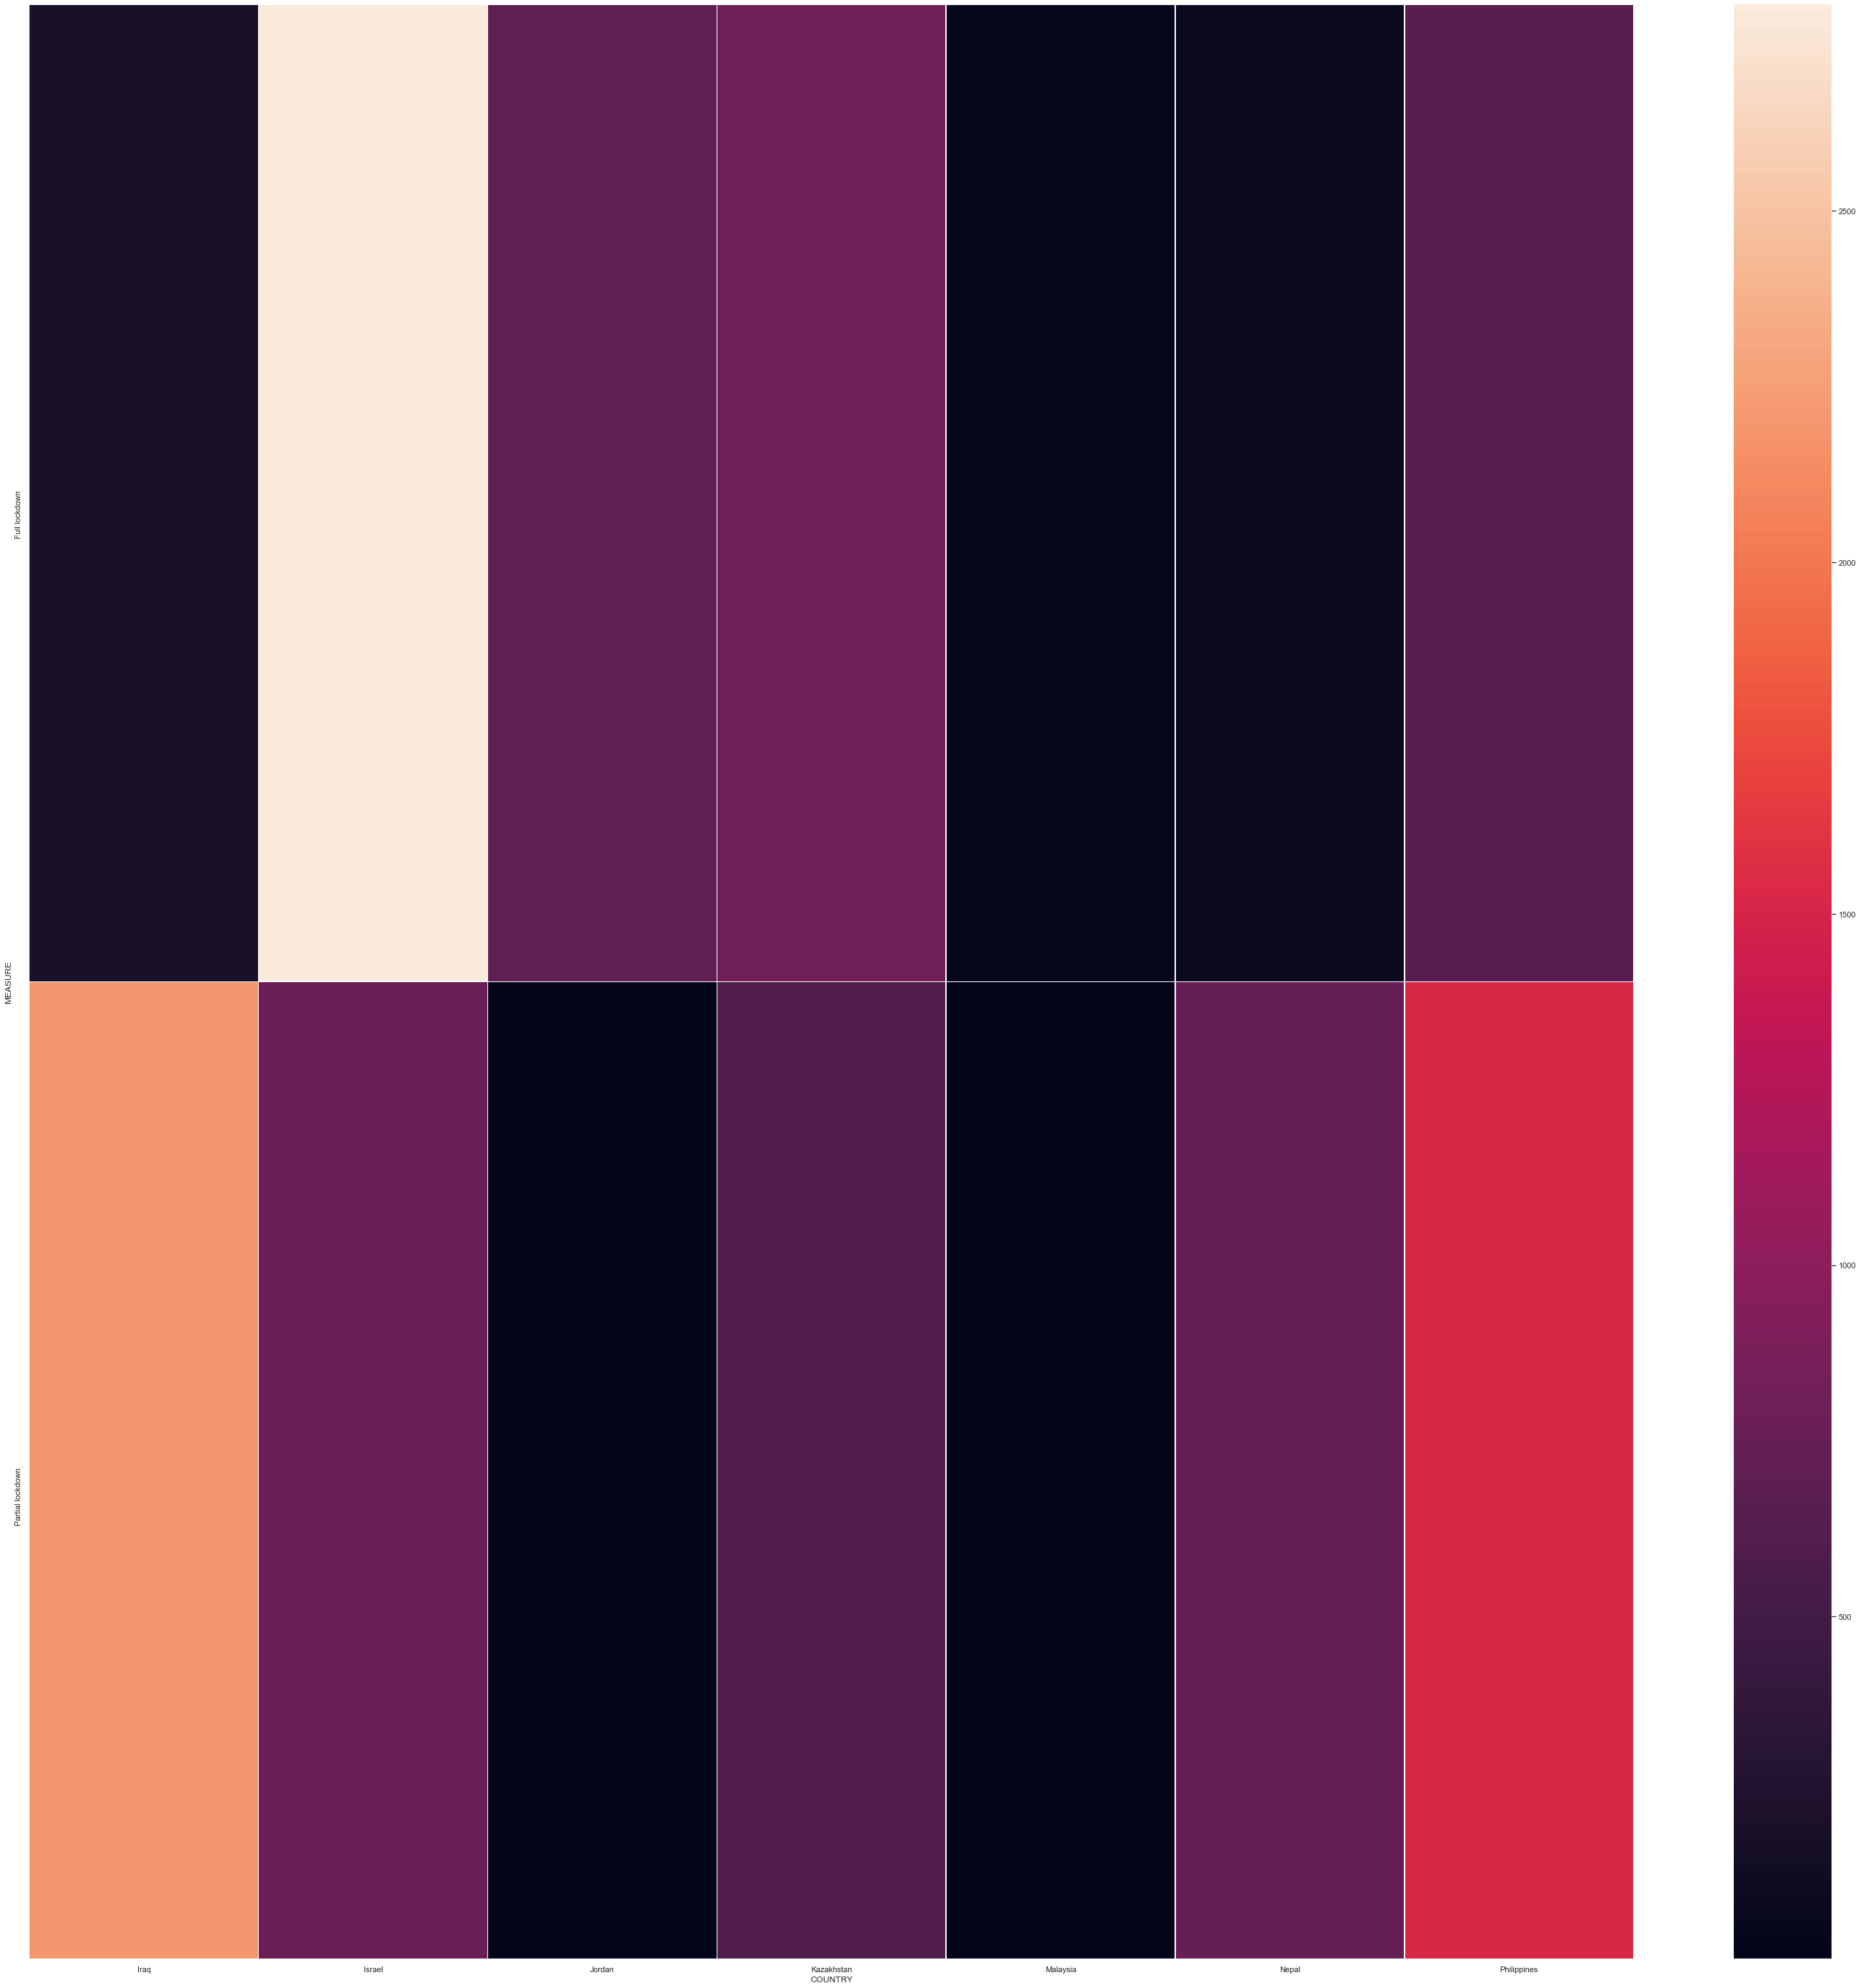

In [35]:
ld_tc_AS_pv=ld_tc_AS.pivot_table(index='MEASURE', columns='COUNTRY', values = 'new_cases')
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(ld_tc_AS_pv,linewidths=.5)

### Iraq

In [36]:
ld_tc_AS_Iraq = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Iraq'])]

In [37]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Iraq)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

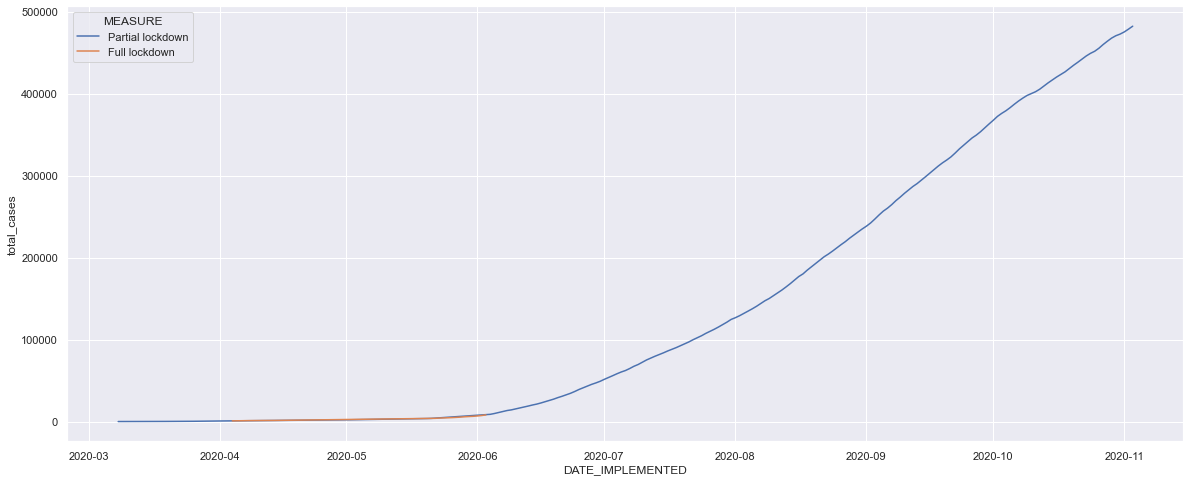

In [38]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Iraq)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

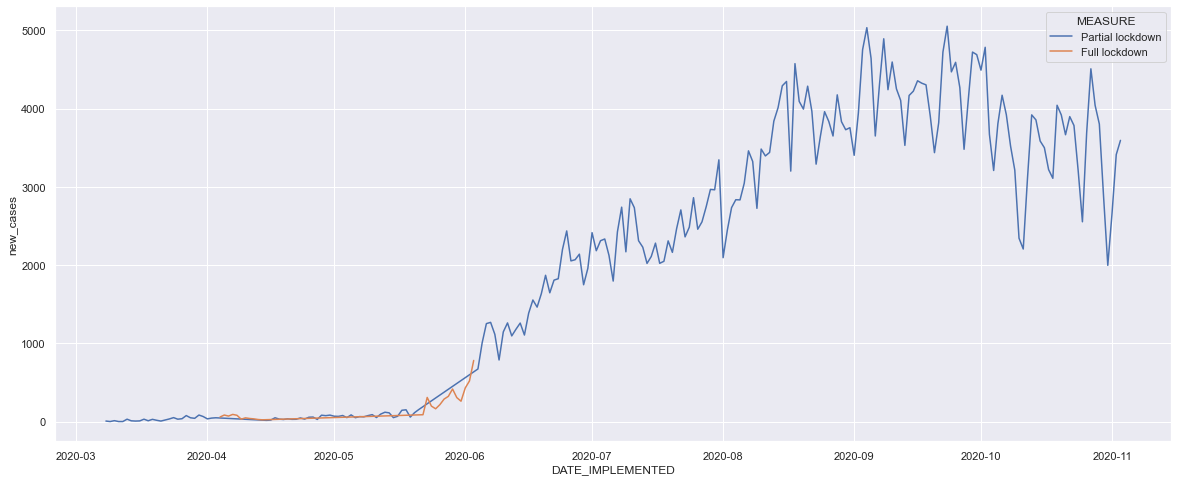

In [39]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Iraq)

### Israel

In [40]:
ld_tc_AS_Israel = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Israel'])]

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

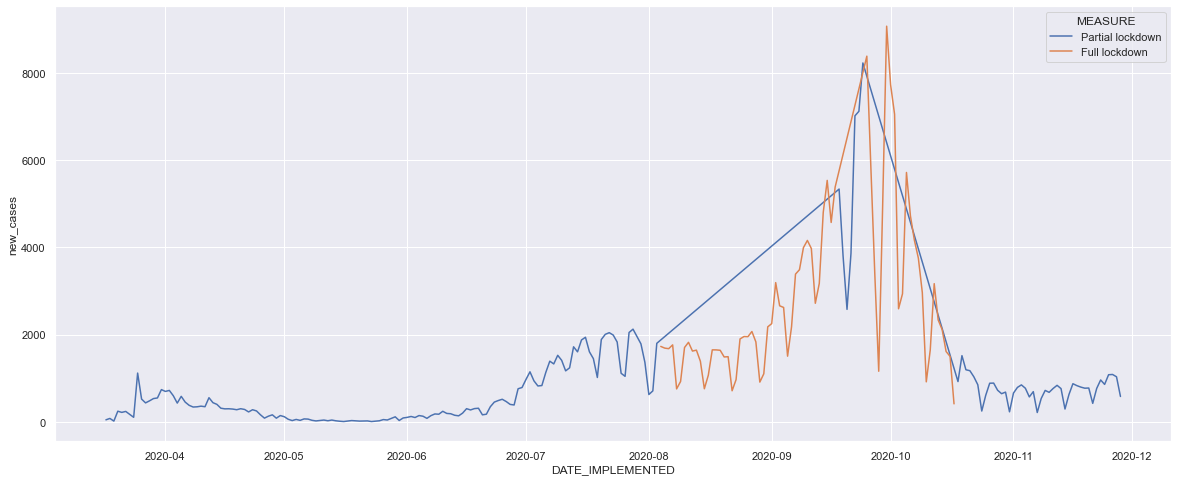

In [41]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Israel)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

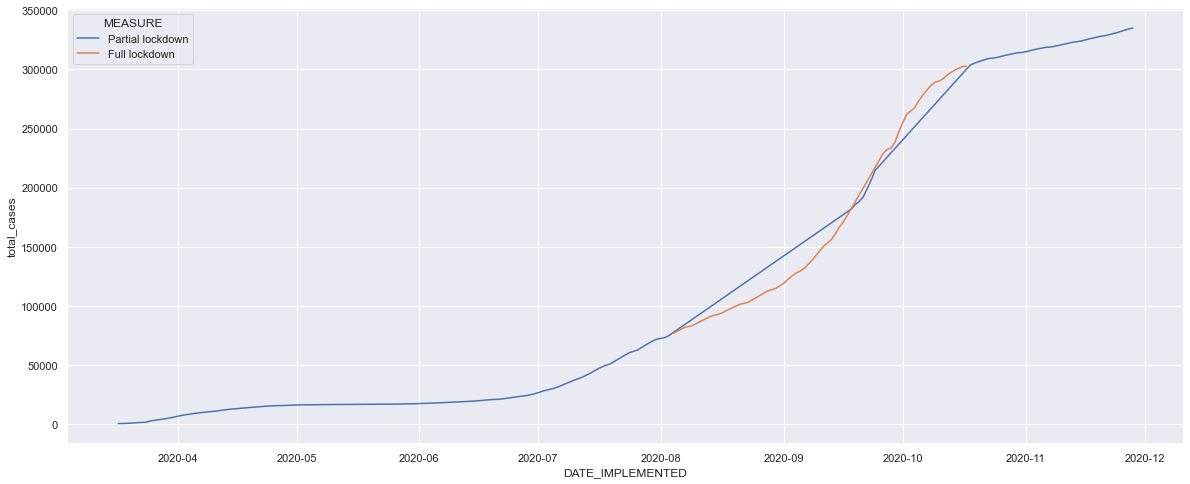

In [42]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Israel)

In [43]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Israel)

### Jordan

In [44]:
ld_tc_AS_Jordan = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Jordan'])]

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

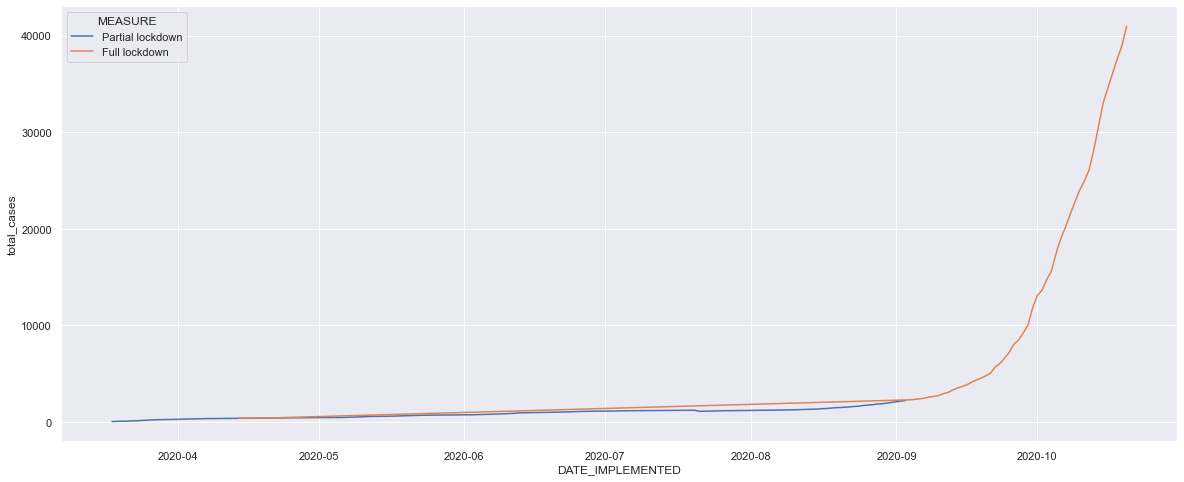

In [45]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Jordan)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

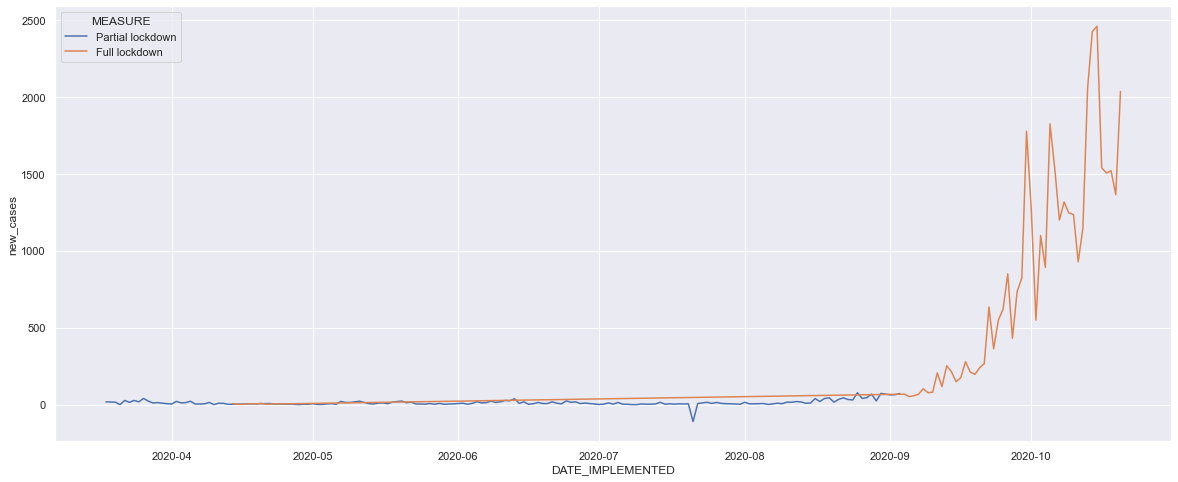

In [46]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Jordan)

In [47]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Jordan)

### Kazakhstan

In [48]:
ld_tc_AS_Kazakhstan = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Kazakhstan'])]

In [49]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Kazakhstan)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

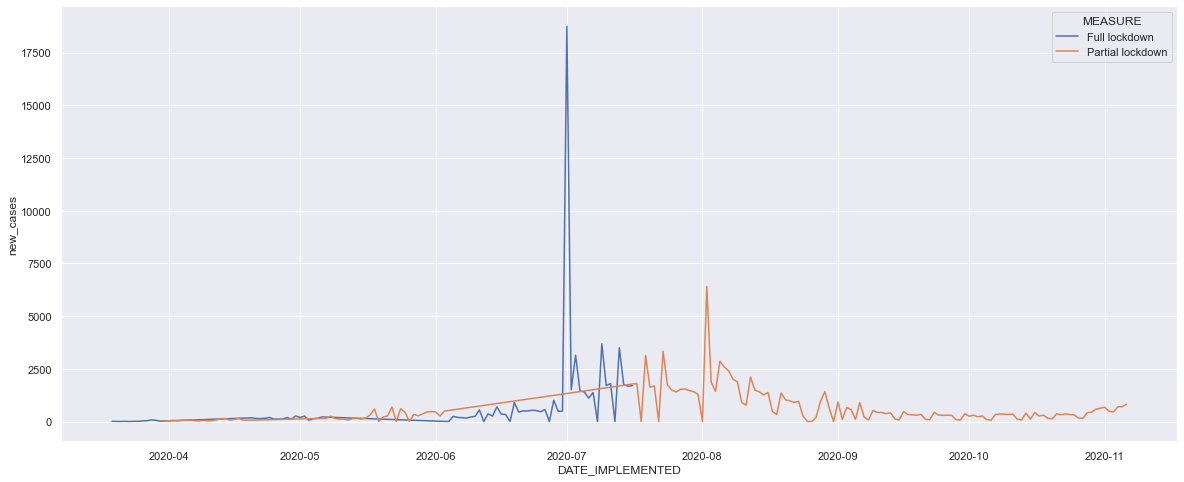

In [50]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Kazakhstan)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

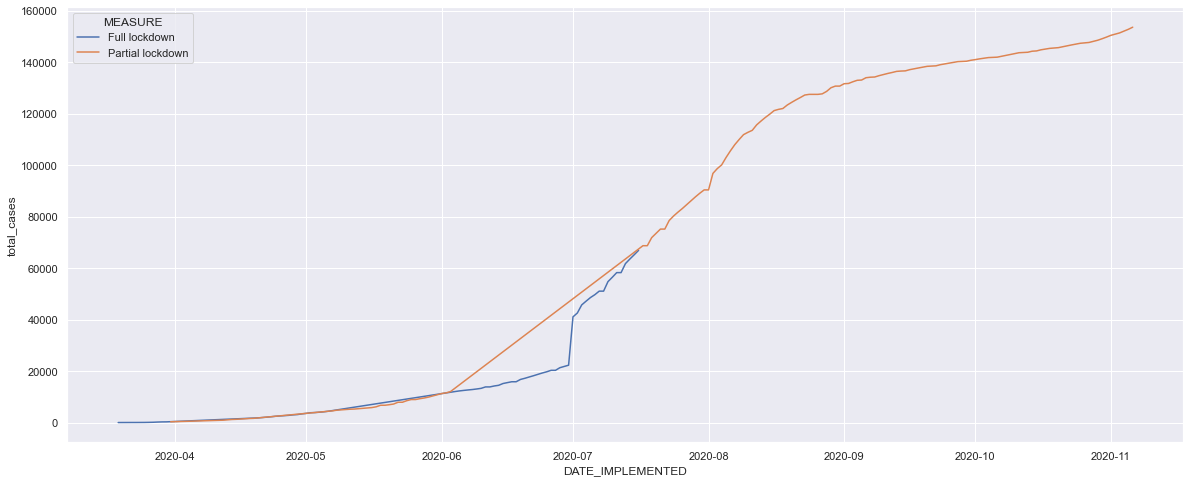

In [51]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Kazakhstan)

### Malaysia

In [52]:
ld_tc_AS_Malaysia = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Malaysia'])]

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

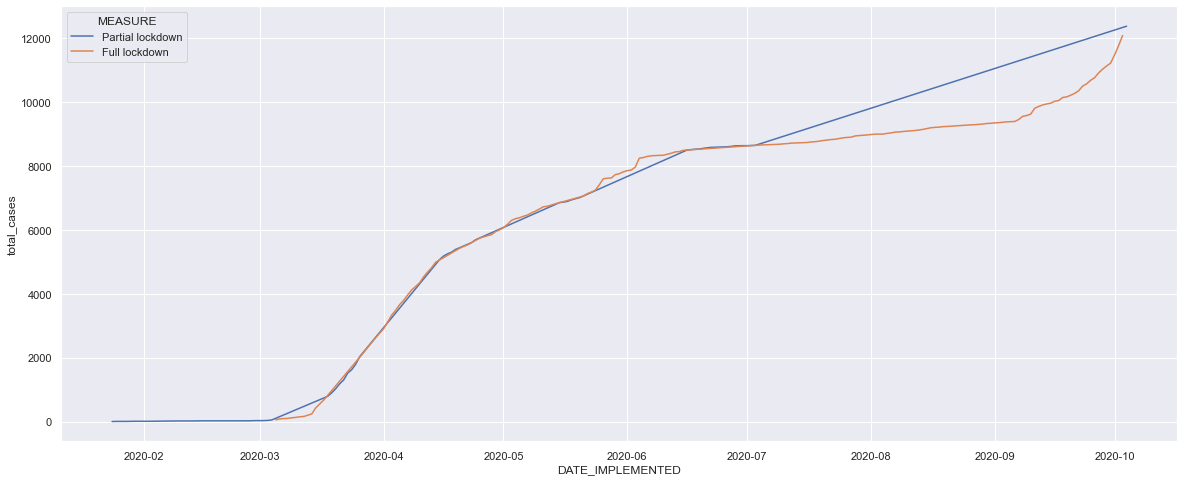

In [53]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Malaysia)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

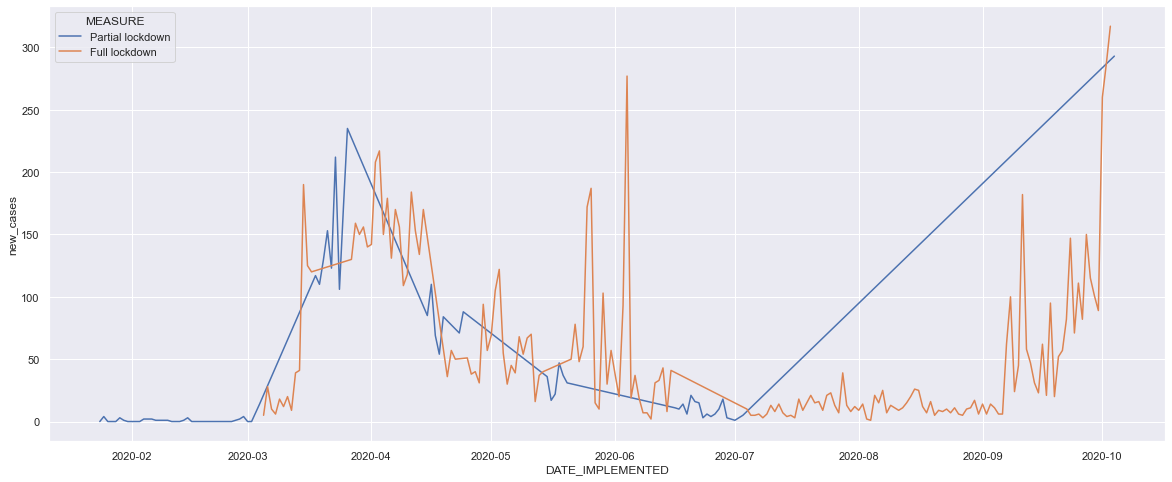

In [54]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Malaysia)

In [55]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Malaysia)

### Nepal

In [56]:
ld_tc_AS_Nepal = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Nepal'])]

In [57]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Nepal)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

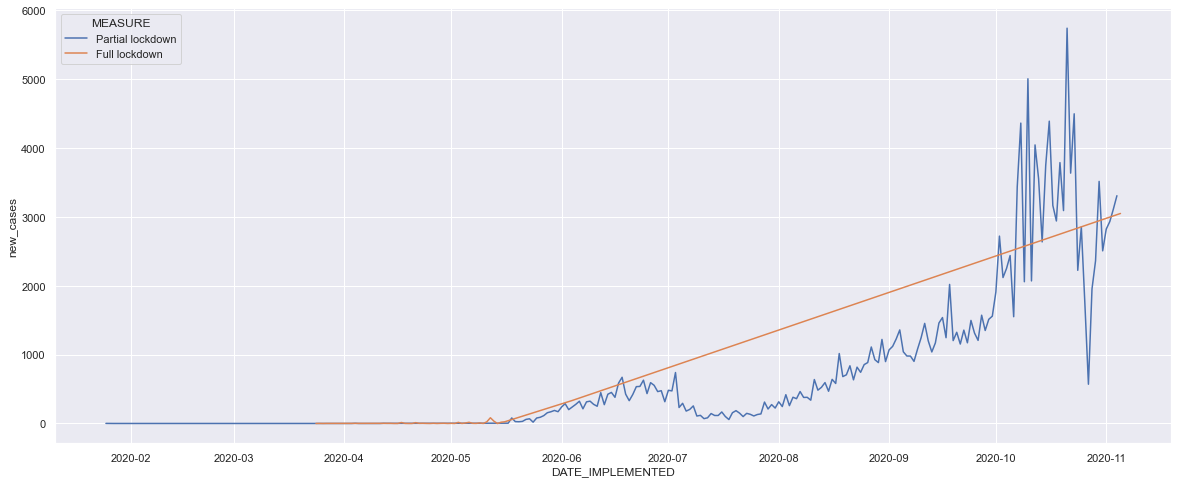

In [58]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Nepal)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

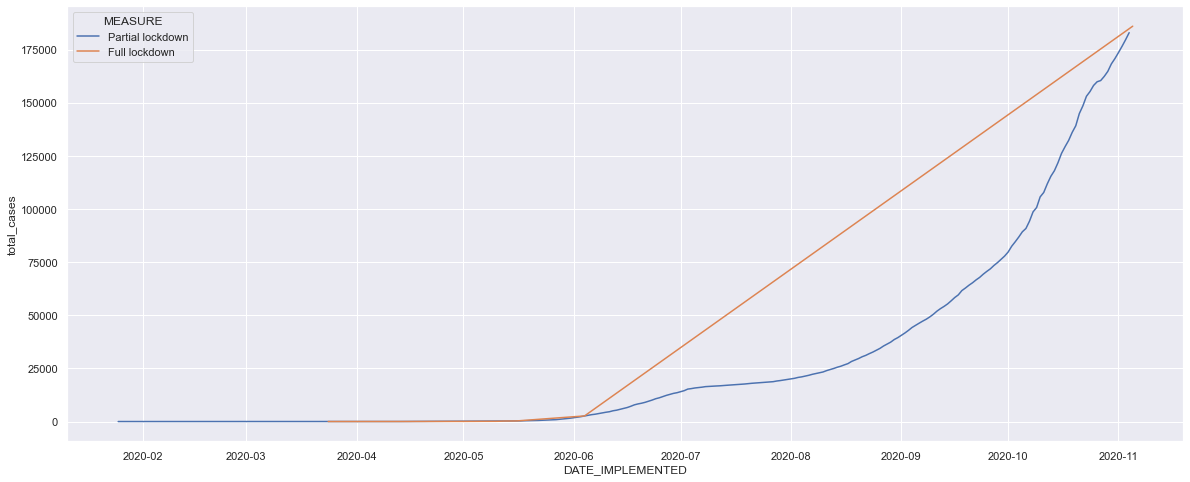

In [59]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Nepal)

### Philippines

In [60]:
ld_tc_AS_Philippines = ld_tc_AS[ld_tc_AS['COUNTRY'].isin(['Philippines'])]

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

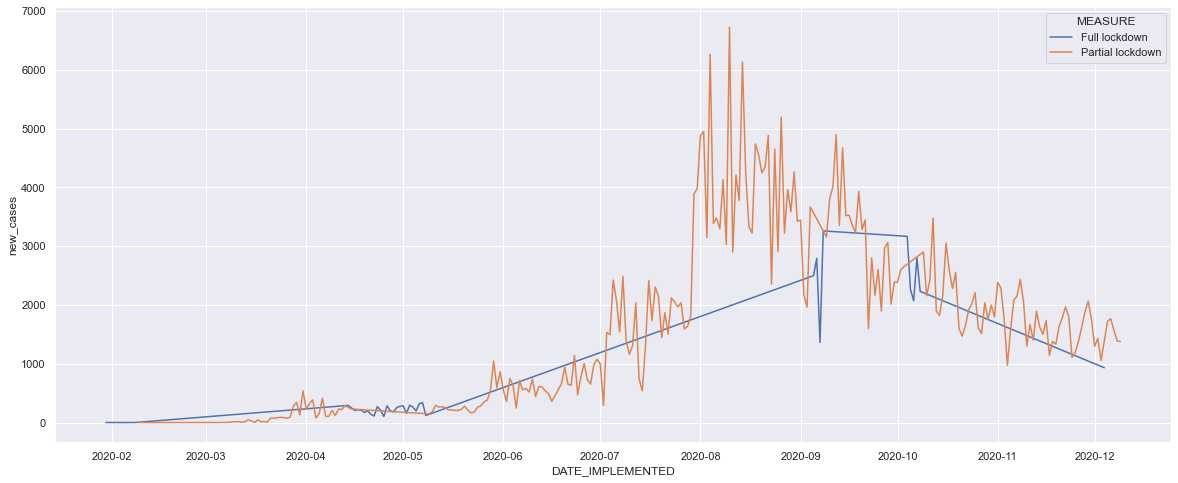

In [61]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=ld_tc_AS_Philippines)

<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='total_cases'>

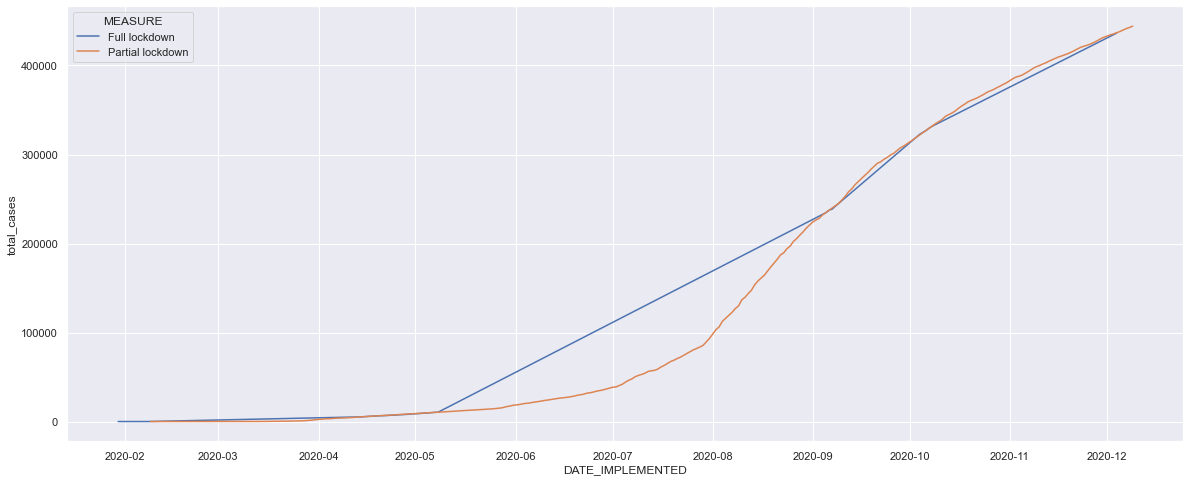

In [62]:
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot('DATE_IMPLEMENTED', 'total_cases', hue='MEASURE', data=ld_tc_AS_Philippines)

In [63]:
# sns.set(rc={'figure.figsize':(20,8)})
# sns.lineplot('DATE_IMPLEMENTED', 'Percentage', hue='MEASURE', data=ld_tc_AS_Philippines)

# Prediction 

## Logistic Regression Model

According to a commonly used algorithm for solving binary classification problems, logistic regression model can be identifed as predictive modeling technique used to find the relationship between a dependent variable and one or more independent variables. In this case, we used Logistic Regression Model for evaluating the relationship between MEASURE, total_cases and new_cases and how the effective model is in each country.

In [64]:
# Change categorical features into numerical ones
ld_tc_trial['MEASURE'].replace({'Full lockdown':1, 'Partial lockdown':0}, inplace=True)
ld_tc_trial.head()
ld_tc_trial[['total_cases', 'new_cases']] = ld_tc_trial[['total_cases','new_cases']].fillna(value=0)

In [65]:
ld_tc_trial.head()

DATE_IMPLEMENTED  COUNTRY  total_cases  new_cases REGION_x  MEASURE
15       2020-03-11  Austria        246.0       64.0   Europe        0
16       2020-03-12  Austria        302.0       56.0   Europe        0
17       2020-03-13  Austria        504.0      202.0   Europe        0
18       2020-03-14  Austria        655.0      151.0   Europe        0
19       2020-03-15  Austria        860.0      205.0   Europe        0

In [66]:
X = ld_tc_trial.drop(['DATE_IMPLEMENTED','COUNTRY','REGION_x','MEASURE'], axis =1)
y = ld_tc_trial['MEASURE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
print('X_train shaper ', X_train.shape)
print('y_train shaper ', y_train.shape)
print('X_test shaper ', X_test.shape)
print('y_test shaper ', y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shaper  (2052, 2)
y_train shaper  (2052,)
X_test shaper  (513, 2)
y_test shaper  (513,)
      total_cases  new_cases
2633       1498.0       16.0
3172      21819.0      492.0
4542      74745.0     1351.0
3223     123325.0     1352.0
4379         31.0        1.0
2633    0
3172    1
4542    0
3223    0
4379    1
Name: MEASURE, dtype: int64


In [67]:
# Create logistic model
model = LogisticRegression()
model.fit(X_train, y_train)
# Do predictions on test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test,y_hat_test))

Accuracy score on training set:  0.6388888888888888
Accuracy score on testing set:  0.631578947368421


Confusion matrix on the test set: 


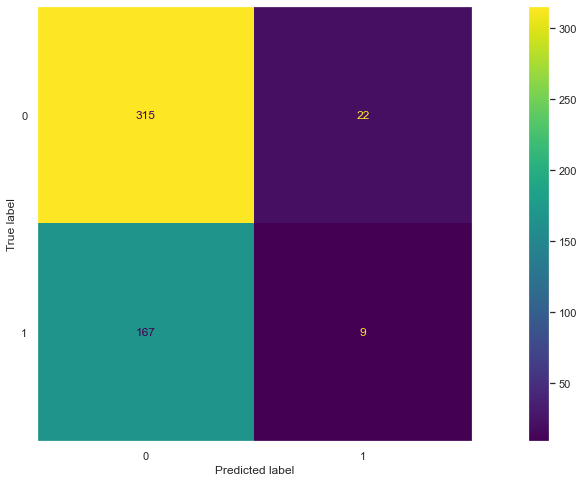

In [68]:
print("Confusion matrix on the test set: ")
cm = confusion_matrix(y_test, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

The confusion matrix provide information what are the true negative and true positive the model is making. According to the confusion matrix above, the model tends to predict Full Lockdown seems to be more effective than Partial Lockdown and in reality Full lockdown also is better than Partial Lockdown 

In [69]:
def logistic(country):
    ld_tc_trial_lg = ld_tc_trial[(ld_tc_trial['COUNTRY']== country)]
    # Split train and test data
    # Full Lockdown
    train, test = train_test_split(ld_tc_trial_lg, test_size=0.2, random_state=142)
    print(test.shape)
    print(train.shape)
    #Create training test
    X_train = train[['new_cases','total_cases',]]
    y_train = train['MEASURE']
    #Create testing test
    X_test = test[['new_cases','total_cases']]
    y_test = test['MEASURE']
    # Create Logistic Regression Model
    print('X_train shaper ', X_train.shape)
    print('y_train shaper ', y_train.shape)
    print('X_test shaper ', X_test.shape)
    print('y_test shaper ', y_test.shape)
    print(X_train.head())
    print(y_train.head())
    #Create logistic model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # Do predictions on test set
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
    print("Accuracy score on testing set: ", accuracy_score(y_test,y_hat_test))
    # Do confusion matrix based on logistic regresison model
    print("Confusion matrix on the test set: ")
    cm = confusion_matrix(y_test, y_hat_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.grid(False)
    plt.show()

(51, 6)
(201, 6)
X_train shaper  (201, 2)
y_train shaper  (201,)
X_test shaper  (51, 2)
y_test shaper  (51,)
     new_cases  total_cases
19       205.0        860.0
58        77.0      15002.0
79        61.0      16058.0
174      164.0      23534.0
183      327.0      26033.0
19     0
58     0
79     0
174    1
183    1
Name: MEASURE, dtype: int64
Accuracy score on training set:  1.0
Accuracy score on testing set:  1.0
Confusion matrix on the test set: 


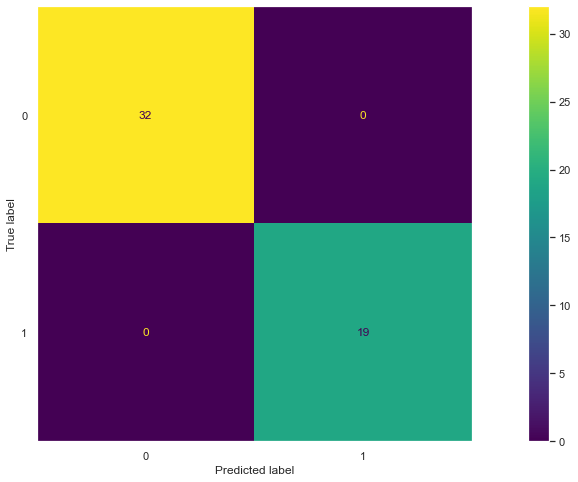

In [70]:
logistic('Austria')

(46, 6)
(184, 6)
X_train shaper  (184, 2)
y_train shaper  (184,)
X_test shaper  (46, 2)
y_test shaper  (46,)
      new_cases  total_cases
2068     1912.0     306235.0
1912     3370.0     187327.0
1956      518.0     234531.0
2098    21273.0     525782.0
2046     1397.0     272912.0
2068    0
1912    0
1956    1
2098    1
2046    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.32065217391304346
Accuracy score on testing set:  0.43478260869565216
Confusion matrix on the test set: 


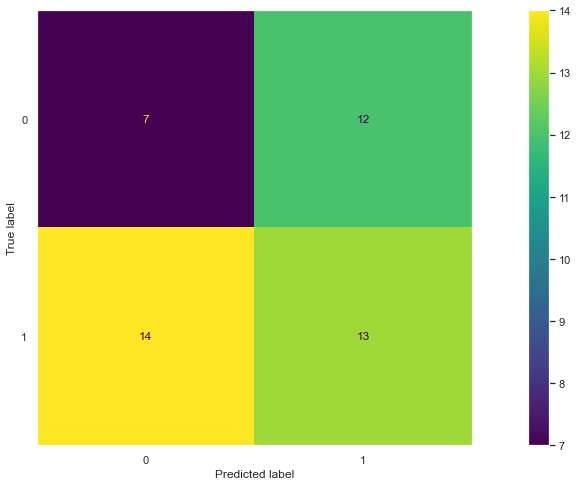

In [71]:
logistic('Italy')

(56, 6)
(223, 6)
X_train shaper  (223, 2)
y_train shaper  (223,)
X_test shaper  (56, 2)
y_test shaper  (56,)
      new_cases  total_cases
5783     8959.0     488513.0
5749     3092.0     288522.0
5593        7.0         13.0
5694      332.0     241310.0
5621     9630.0      49515.0
5783    0
5749    0
5593    1
5694    1
5621    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.4170403587443946
Accuracy score on testing set:  0.35714285714285715
Confusion matrix on the test set: 


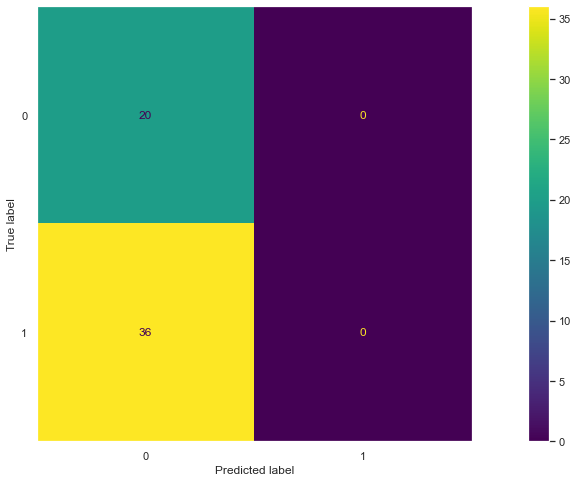

In [72]:
logistic('Spain')

(49, 6)
(192, 6)
X_train shaper  (192, 2)
y_train shaper  (192,)
X_test shaper  (49, 2)
y_test shaper  (49,)
     new_cases  total_cases
824     3481.0     349450.0
638       30.0        346.0
699      163.0       4632.0
681       63.0       2543.0
856     3804.0     467755.0
824    0
638    0
699    1
681    0
856    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.8958333333333334
Accuracy score on testing set:  0.9183673469387755
Confusion matrix on the test set: 


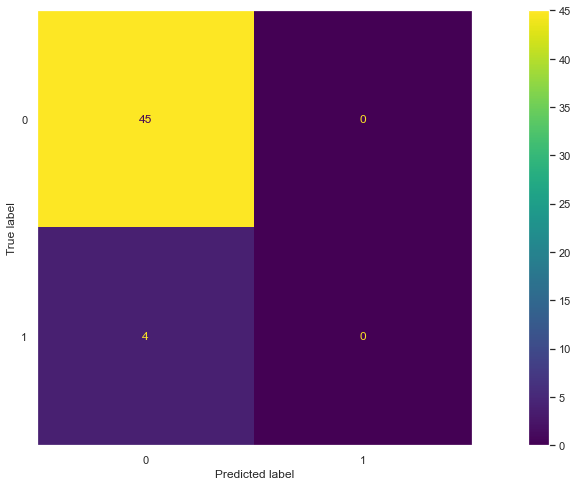

In [73]:
logistic('Iraq')

(52, 6)
(205, 6)
X_train shaper  (205, 2)
y_train shaper  (205,)
X_test shaper  (52, 2)
y_test shaper  (52,)
      new_cases  total_cases
1381      708.0      73067.0
1467      887.0     312074.0
1417     3388.0     134705.0
1450      916.0     289974.0
1247      215.0        843.0
1381    0
1467    0
1417    1
1450    1
1247    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.5609756097560976
Accuracy score on testing set:  0.5961538461538461
Confusion matrix on the test set: 


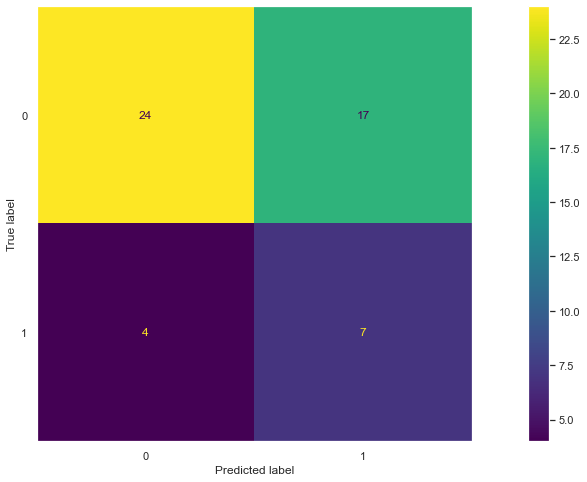

In [74]:
logistic('Israel')

(44, 6)
(173, 6)
X_train shaper  (173, 2)
y_train shaper  (173,)
X_test shaper  (44, 2)
y_test shaper  (44,)
      new_cases  total_cases
2640       45.0       1801.0
2587       14.0       1164.0
2511        8.0        425.0
2535        4.0        586.0
2543       16.0        700.0
2640    0
2587    0
2511    1
2535    0
2543    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.9364161849710982
Accuracy score on testing set:  0.9318181818181818
Confusion matrix on the test set: 


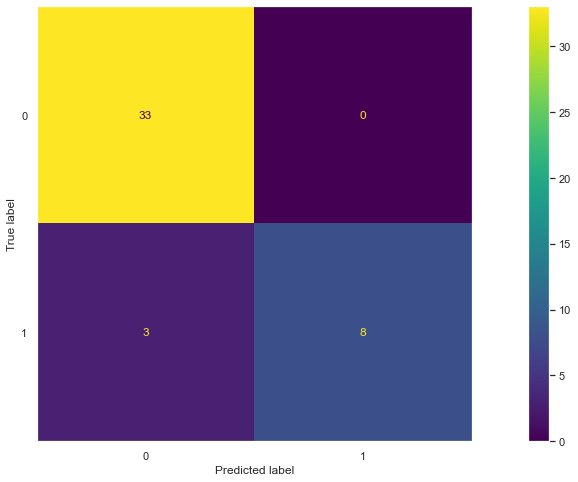

In [75]:
logistic('Jordan')

(47, 6)
(186, 6)
X_train shaper  (186, 2)
y_train shaper  (186,)
X_test shaper  (47, 2)
y_test shaper  (47,)
      new_cases  total_cases
3103      143.0       1995.0
3147        0.0      12067.0
3254      300.0     138013.0
3223     1352.0     123325.0
3278       74.0     143814.0
3103    1
3147    1
3254    0
3223    0
3278    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.7043010752688172
Accuracy score on testing set:  0.7021276595744681
Confusion matrix on the test set: 


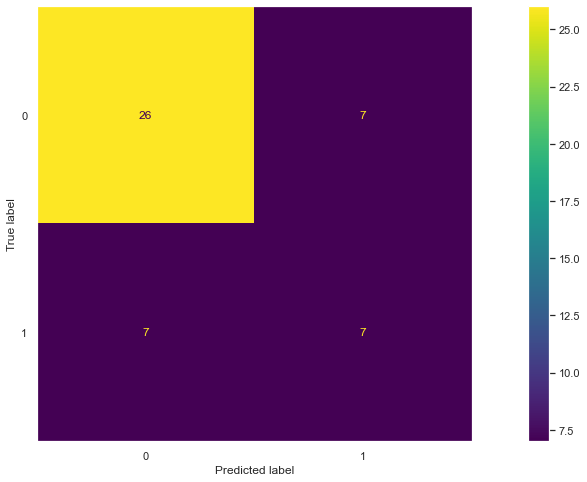

In [76]:
logistic('Kazakhstan')

(63, 6)
(252, 6)
X_train shaper  (252, 2)
y_train shaper  (252,)
X_test shaper  (63, 2)
y_test shaper  (63,)
      new_cases  total_cases
5053      539.0      15588.0
5103     1735.0      63001.0
5024      254.0       8212.0
5220     1667.0     401416.0
5099      747.0      57006.0
5053    0
5103    0
5024    1
5220    0
5099    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.8531746031746031
Accuracy score on testing set:  0.8888888888888888
Confusion matrix on the test set: 


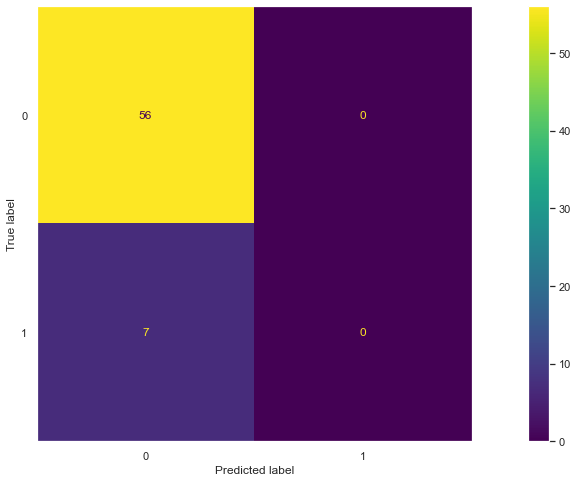

In [77]:
logistic('Philippines')

(51, 6)
(204, 6)
X_train shaper  (204, 2)
y_train shaper  (204,)
X_test shaper  (51, 2)
y_test shaper  (51,)
      new_cases  total_cases
3722      140.0       2766.0
3793        2.0       8338.0
3869       11.0       9285.0
3829        3.0       8737.0
3861       12.0       9212.0
3722    1
3793    1
3869    1
3829    1
3861    1
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.803921568627451
Accuracy score on testing set:  0.7843137254901961
Confusion matrix on the test set: 


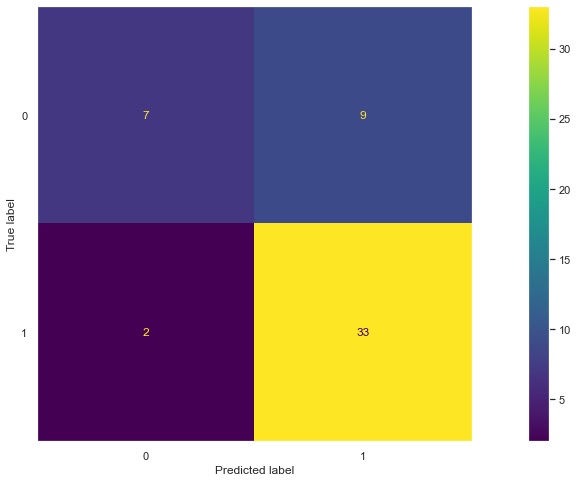

In [78]:
logistic('Malaysia')

(58, 6)
(228, 6)
X_train shaper  (228, 2)
y_train shaper  (228,)
X_test shaper  (58, 2)
y_test shaper  (58,)
      new_cases  total_cases
4384        3.0         48.0
4360        0.0          5.0
4493      338.0      23310.0
4407       24.0        291.0
4328        0.0          1.0
4384    1
4360    0
4493    0
4407    1
4328    0
Name: MEASURE, dtype: int64
Accuracy score on training set:  0.8552631578947368
Accuracy score on testing set:  0.8793103448275862
Confusion matrix on the test set: 


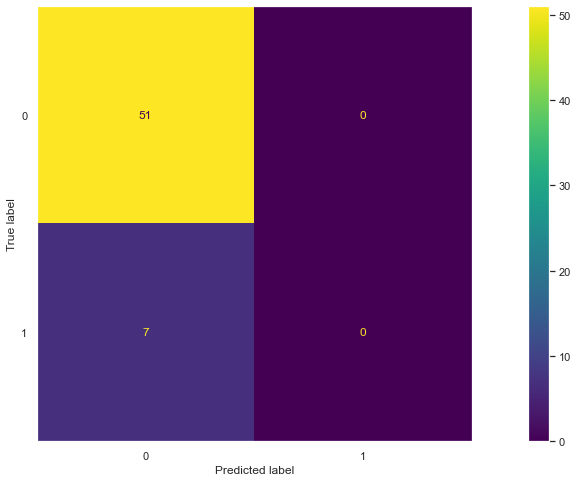

In [79]:
logistic('Nepal')

## Linear Regression

Linear regression is a basic and commonly used type of predictive analysis. The purpose of the model is to predict variables (total_cases and MEASURE) do a good job in predicting an outcome (new_cases) variable.

In [80]:
def predict(country):
    ld_tc_trial_1 = ld_tc_trial[(ld_tc_trial['COUNTRY']== country) & (ld_tc_trial['MEASURE']==1)]
    ld_tc_trial_0 = ld_tc_trial[(ld_tc_trial['COUNTRY']== country) & (ld_tc_trial['MEASURE']==0)]
    # Split train and test data
    # Full Lockdown
    train_1, test_1 = train_test_split(ld_tc_trial_1, test_size=0.2, random_state=142)
    print(test_1.shape)
    print(train_1.shape)
    #Create training test
    X_train_1 = train_1[['MEASURE','total_cases',]]
    y_train_1 = train_1['new_cases']
    #Create testing test
    X_test_1 = test_1[['MEASURE','total_cases']]
    y_test_1 = test_1['new_cases']
    # Create Linear model
    reg = linear_model.LinearRegression()
    reg.fit(X_train_1, y_train_1)

    predicted_1 = reg.predict(X_test_1)
    mse = mean_squared_error(y_test_1, predicted_1)
    r2 = r2_score(y_test_1, predicted_1)
    print("MSE of full lockdown dataset:", mse)
    print("Root MSE of full lockdown dataset:", np.sqrt(mse))
    print("R Squared of full lockdown dataset:", r2)
    #Partial Lockdown
    train_0, test_0 = train_test_split(ld_tc_trial_0, test_size=0.2, random_state=142)
    print(test_0.shape)
    print(train_0.shape)

    X_train_0 = train_0[['MEASURE','total_cases']]
    y_train_0 = train_0['new_cases']

    X_test_0 = test_0[['MEASURE','total_cases']]
    y_test_0 = test_0['new_cases']
    #Create Linear Model
    reg = linear_model.LinearRegression()
    reg.fit(X_train_0, y_train_0)
    
    predicted_0 = reg.predict(X_test_0)
    mse = mean_squared_error(y_test_0, predicted_0)
    r2 = r2_score(y_test_0, predicted_0)
    print("MSE of partial lockdown dataset when implements partial lockdown:", mse)
    print("Root MSE of partial lockdown dataset when implements partial lockdown:", np.sqrt(mse))
    print("R Squared of partial lockdown dataset when implements partial lockdown:", r2)
    # Data Visualizing
    sns.lmplot(x = 'new_cases', y = 'total_cases',hue = 'MEASURE', data = ld_tc_trial_1)
    plt.title('New cases during Full Lockdown ')
    sns.lmplot(x = 'new_cases', y = 'total_cases', hue = 'MEASURE',data = ld_tc_trial_0)
    plt.title('New cases during Partial Lockdown')

(20, 6)
(79, 6)
MSE of full lockdown dataset: 182548.01902714407
Root MSE of full lockdown dataset: 427.2563855896645
R Squared of full lockdown dataset: 0.9590249007673938
(31, 6)
(122, 6)
MSE of partial lockdown dataset when implements partial lockdown: 29307.590416891755
Root MSE of partial lockdown dataset when implements partial lockdown: 171.19459809495086
R Squared of partial lockdown dataset when implements partial lockdown: -9.362180968129342


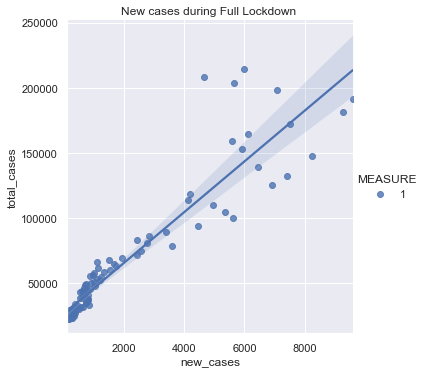

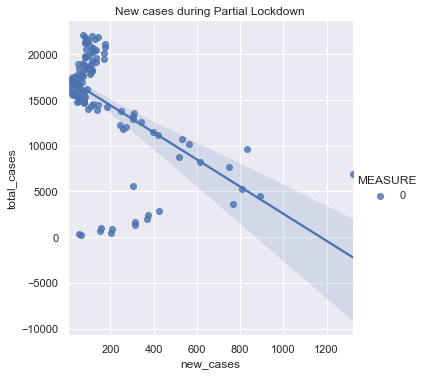

In [81]:
predict('Austria')

The plot for predicted data for both full lockdown and partial lockdown shows the correlation between MEASURE, total_cases and new_cases. In addition, the plot also shows the downward trend in Partial Lockdown while the upward  trend in Full Lockdown
R-square of full lockdown measurement (0.96) is good, but MSE is large. The model may be overfitting.
R-square of partial lockdown measurement (-9.3) show that it doesn’t make any sense given the trend of the actual data points, and it is clearly a wrong model.

(25, 6)
(98, 6)
MSE of full lockdown dataset: 14879858.82060876
Root MSE of full lockdown dataset: 3857.4420048276497
R Squared of full lockdown dataset: 0.7389177300152971
(22, 6)
(85, 6)
MSE of partial lockdown dataset when implements partial lockdown: 931798.688257562
Root MSE of partial lockdown dataset when implements partial lockdown: 965.2972020354985
R Squared of partial lockdown dataset when implements partial lockdown: 0.537768107327846


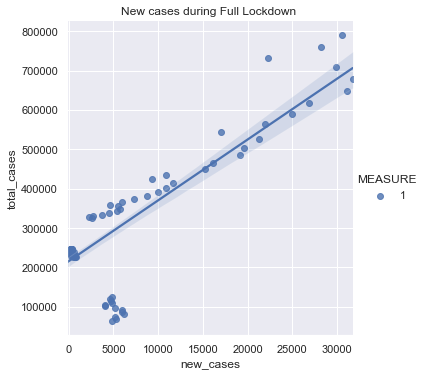

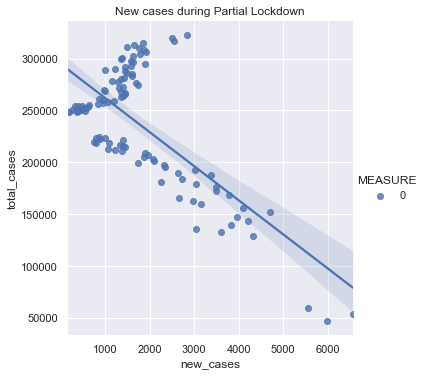

In [82]:
predict('Italy')

The plot for predicted data for both full lockdown and partial lockdown shows the correlation between MEASURE, total_cases and new_cases. In addition, the plot also shows the downward trend in Partial Lockdown while the upward trend in Full Lockdown R-square of full lockdown measurement (0.97) is good, but MSE is large. The model may be overfitting. R-square of partial lockdown measurement (0.5) show a low correlation.

(34, 6)
(134, 6)
MSE of full lockdown dataset: 18349077.156029742
Root MSE of full lockdown dataset: 4283.582280758681
R Squared of full lockdown dataset: 0.05015566111582992
(23, 6)
(88, 6)
MSE of partial lockdown dataset when implements partial lockdown: 43173461.50759263
Root MSE of partial lockdown dataset when implements partial lockdown: 6570.651528394474
R Squared of partial lockdown dataset when implements partial lockdown: 0.0835575521696933


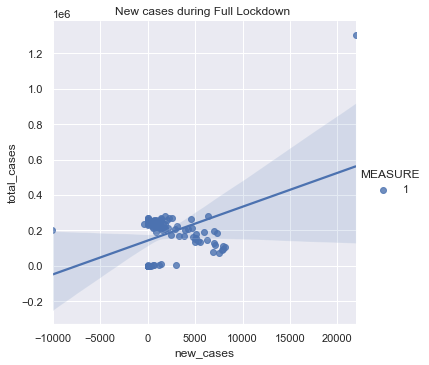

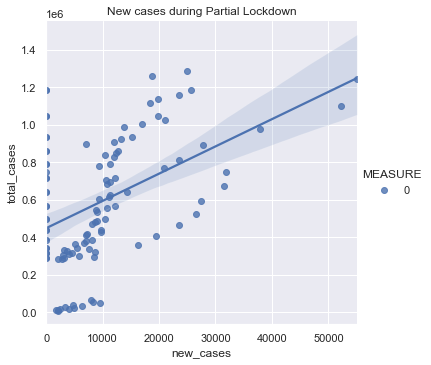

In [83]:
predict('Spain')

(5, 6)
(19, 6)
MSE of full lockdown dataset: 5817.782003715578
Root MSE of full lockdown dataset: 76.27438628868526
R Squared of full lockdown dataset: -0.2510928664208494
(44, 6)
(173, 6)
MSE of partial lockdown dataset when implements partial lockdown: 874815.5112464435
Root MSE of partial lockdown dataset when implements partial lockdown: 935.3157281081311
R Squared of partial lockdown dataset when implements partial lockdown: 0.6931174625566958


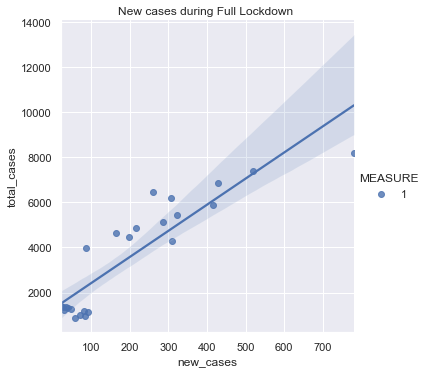

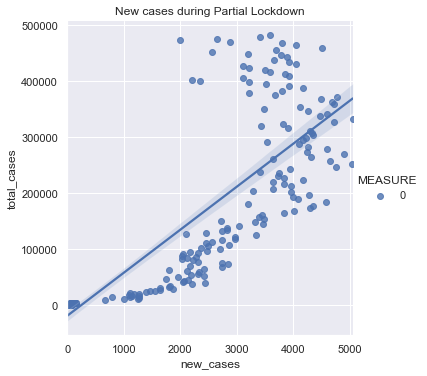

In [84]:
predict('Iraq')

(14, 6)
(54, 6)
MSE of full lockdown dataset: 2588309.125535448
Root MSE of full lockdown dataset: 1608.8222790399964
R Squared of full lockdown dataset: 0.15204432658627876
(38, 6)
(151, 6)
MSE of partial lockdown dataset when implements partial lockdown: 1355034.13049908
Root MSE of partial lockdown dataset when implements partial lockdown: 1164.0593328946252
R Squared of partial lockdown dataset when implements partial lockdown: 0.08408277211212001


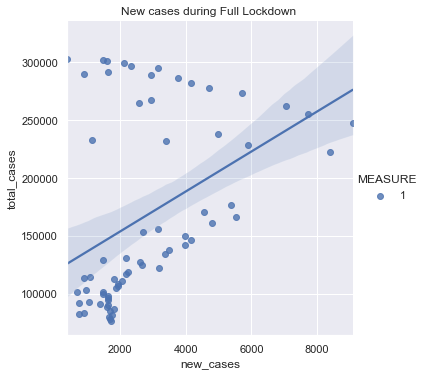

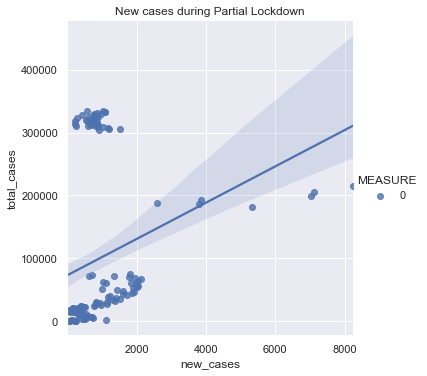

In [85]:
predict('Israel')

(11, 6)
(44, 6)
MSE of full lockdown dataset: 245831.55091707743
Root MSE of full lockdown dataset: 495.81402856018246
R Squared of full lockdown dataset: 0.5104048348486954
(33, 6)
(129, 6)
MSE of partial lockdown dataset when implements partial lockdown: 169.79841189368392
Root MSE of partial lockdown dataset when implements partial lockdown: 13.03067196631409
R Squared of partial lockdown dataset when implements partial lockdown: 0.2632638053428408


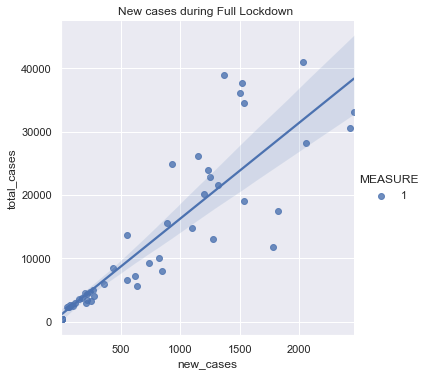

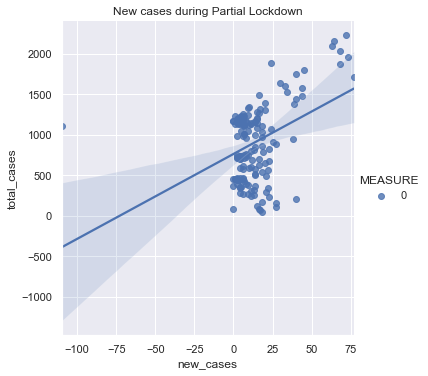

In [86]:
predict('Jordan')

(15, 6)
(57, 6)
MSE of full lockdown dataset: 141746.16909419728
Root MSE of full lockdown dataset: 376.4919243412763
R Squared of full lockdown dataset: 0.4840021992201101
(33, 6)
(128, 6)
MSE of partial lockdown dataset when implements partial lockdown: 604865.6121330531
Root MSE of partial lockdown dataset when implements partial lockdown: 777.7310667146152
R Squared of partial lockdown dataset when implements partial lockdown: -0.005617426185544838


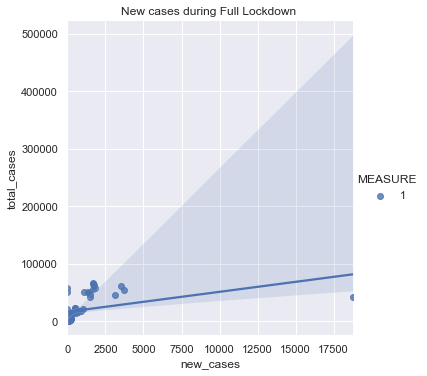

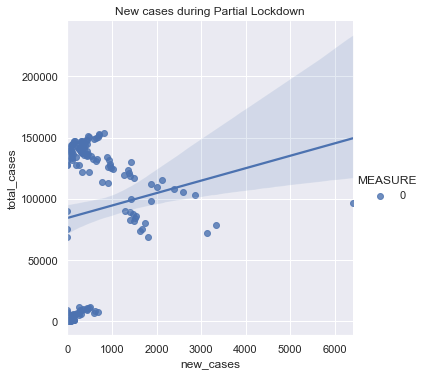

In [87]:
predict('Kazakhstan')

(35, 6)
(138, 6)
MSE of full lockdown dataset: 5171.615992074326
Root MSE of full lockdown dataset: 71.91394852234389
R Squared of full lockdown dataset: -0.07526325433154168
(17, 6)
(65, 6)
MSE of partial lockdown dataset when implements partial lockdown: 4480.040652468366
Root MSE of partial lockdown dataset when implements partial lockdown: 66.93310580324483
R Squared of partial lockdown dataset when implements partial lockdown: -0.10224832760955627


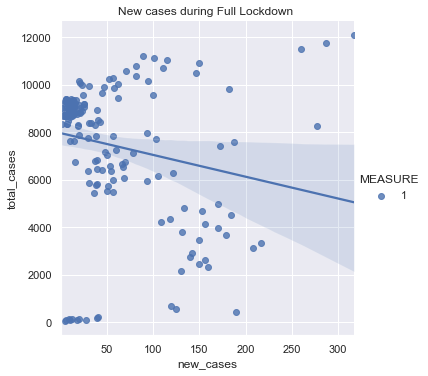

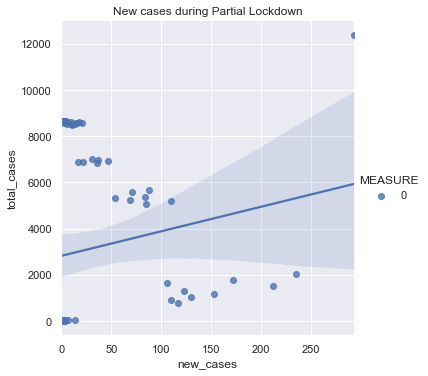

In [88]:
predict('Malaysia')

(9, 6)
(35, 6)
MSE of full lockdown dataset: 19507.578957842612
Root MSE of full lockdown dataset: 139.66953482360643
R Squared of full lockdown dataset: 0.9568455857476692
(55, 6)
(216, 6)
MSE of partial lockdown dataset when implements partial lockdown: 1793047.1740920728
Root MSE of partial lockdown dataset when implements partial lockdown: 1339.0471142167003
R Squared of partial lockdown dataset when implements partial lockdown: 0.2616965250994583


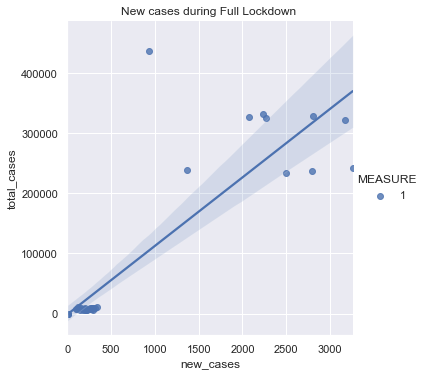

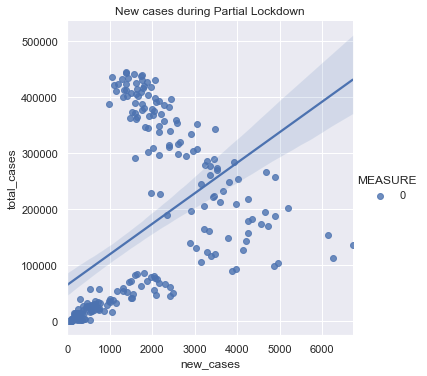

In [89]:
predict('Philippines')

(8, 6)
(32, 6)
MSE of full lockdown dataset: 11201.87932350091
Root MSE of full lockdown dataset: 105.8389310391073
R Squared of full lockdown dataset: 0.018713212430387594
(50, 6)
(196, 6)
MSE of partial lockdown dataset when implements partial lockdown: 110913.73742709885
Root MSE of partial lockdown dataset when implements partial lockdown: 333.0371412126564
R Squared of partial lockdown dataset when implements partial lockdown: 0.896983274271758


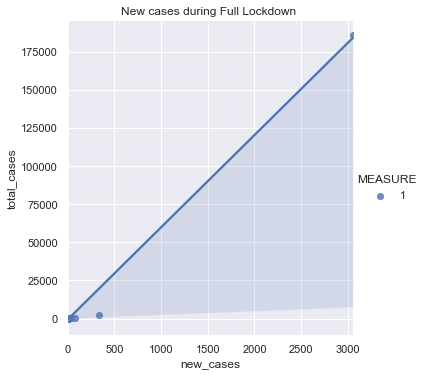

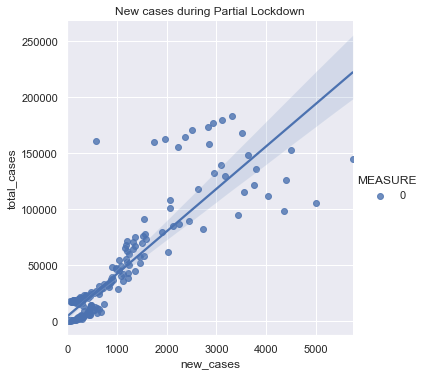

In [90]:
predict('Nepal')

## Time Series Model
* [Prophet model](https://facebook.github.io/prophet/docs/quick_start.html) will be used to predict the trend of new cases that might increase or decrease in the future with measurement Partial and Full lockdown. 
* [Cross-Validation](https://facebook.github.io/prophet/docs/diagnostics.html) will be used to measured forecast error and calculate R-square.

In [91]:
import warnings; 
warnings.simplefilter('ignore')
#Import prophet model
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
#Function for prophet model fit and visualizing
def forecast(country):
    c1=ld_tc[(ld_tc['COUNTRY']==country) & (ld_tc['MEASURE']=='Full lockdown')] #Create full lockdown dataframe by specific country
    c2=ld_tc[(ld_tc['COUNTRY']==country) & (ld_tc['MEASURE']=='Partial lockdown')] #Create partial lockdown dataframe by specific country and measure
    
    #Change columns name to 'ds' (DATE_IMPLEMENTED) and 'y' (new_cases) as Prophet requires
    #Full lockdown
    c1_1=c1.drop(['COUNTRY','total_cases','REGION_x', 'MEASURE'], axis=1) #Drop unnecessary columns for the model
    c1_1 = c1_1.rename(columns={'DATE_IMPLEMENTED': 'ds', 'new_cases': 'y'})
    #Partial lockdown
    c2_1=c2.drop(['COUNTRY','total_cases','REGION_x', 'MEASURE'], axis=1) #Drop unnecessary columns for the model
    c2_1 = c2_1.rename(columns={'DATE_IMPLEMENTED': 'ds', 'new_cases': 'y'})
    
    #Make the prophet model and fit on the data
    #Full lockdown
    c1_prophet = Prophet()
    c1_prophet.fit(c1_1)
    #Partial lockdown
    c2_prophet = Prophet()
    c2_prophet.fit(c2_1)
    
    #Make a future dataframe for 1 year
    c1_forecast = c1_prophet.make_future_dataframe(periods=365) #Full lockdown, forecast data for the next 365 days 
    c2_forecast = c2_prophet.make_future_dataframe(periods=365) #Partial lockdown, fforecast data for the next 365 days 
    #Make predictions
    c1_forecast = c1_prophet.predict(c1_forecast) #Full lockdown
    c2_forecast = c2_prophet.predict(c2_forecast) #Partial lockdown
    
    #Data visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle('Voucher used by different measurement')
    #Original data for full lockdown
    sns.lineplot(ax=axes[0][0],data=c1, x='DATE_IMPLEMENTED', y='new_cases', color='tomato', legend=False)
    axes[0][0].set_title('Case Number by Date during Full Lockdown (Original)')
    #Original data for partial lockdown
    sns.lineplot(ax=axes[0][1],data=c2, x='DATE_IMPLEMENTED', y='new_cases', color='lightseagreen', legend=False)
    axes[0][1].set_title('Case Number by Date during Partial Lockdown (Original)')
    #Predicted data for full lockdown
    c1_prophet.plot(c1_forecast, ax=axes[1][0])
    axes[1][0].set_title('Case Number by Date during Full Lockdown (Predicted)')
    #Predicted data for partial lockdown
    c2_prophet.plot(c2_forecast, ax=axes[1][1])
    axes[1][1].set_title('Case Number by Date during Partial Lockdown (Predicted)')
    
    #Cross Validation for non-daily data (there are different lockdown periods)
    #Full lockdown
    date_range=c1_1['ds'].dt.date.max()-c1_1['ds'].dt.date.min()
    print(c1_1.shape)
    df_cv = cross_validation(c1_prophet, initial=str(date_range.days-8)+' days', period='1 days', horizon = '1 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    #plot_cross_validation_metric(df_cv, metric='rmse')
    metric_df = c1_forecast.set_index('ds')[['yhat']].join(c1_1.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True) #Drop missing value
    print("R-square score (full lockdown) is: "+str(r2_score(metric_df.y, metric_df.yhat))) #R-square for the prophet model
    print("MSE value (full lockdown) is: "+str(mean_squared_error(metric_df.y, metric_df.yhat))) #MSE for the prophet model
    print("MAE value (full lockdown) is: "+str(mean_absolute_error(metric_df.y, metric_df.yhat))) #Mean Absolute Error for the prophet model
    #Partial lockdown
    date_range=c2_1['ds'].dt.date.max()-c2_1['ds'].dt.date.min()
    print(c2_1.shape)
    df_cv = cross_validation(c2_prophet, initial=str(date_range.days-8)+' days', period='1 days', horizon = '1 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    metric_df = c2_forecast.set_index('ds')[['yhat']].join(c2_1.set_index('ds').y).reset_index()
    metric_df.dropna(inplace=True) #Drop missing value
    print("R-square score (partial lockdown) is: "+str(r2_score(metric_df.y, metric_df.yhat))) #R-square for the prophet model
    print("MSE value (partial lockdown) is: "+str(mean_squared_error(metric_df.y, metric_df.yhat)))#MSE for the prophet model
    print("MAE value (partial lockdown) is: "+str(mean_absolute_error(metric_df.y, metric_df.yhat))) #Mean Absolute Error for the prophet model

**Austria**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-11-09 00:00:00 and 2020-11-16 00:00:00


(99, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Making 8 forecasts with cutoffs between 2020-08-02 00:00:00 and 2020-08-09 00:00:00


R-square score (full lockdown) is: 0.9228543183922637
MSE value (full lockdown) is: 434548.9076356679
MAE value (full lockdown) is: 443.94916557799604
(153, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.45402131425970416
MSE value (partial lockdown) is: 20639.271000093784
MAE value (partial lockdown) is: 78.61150665811421


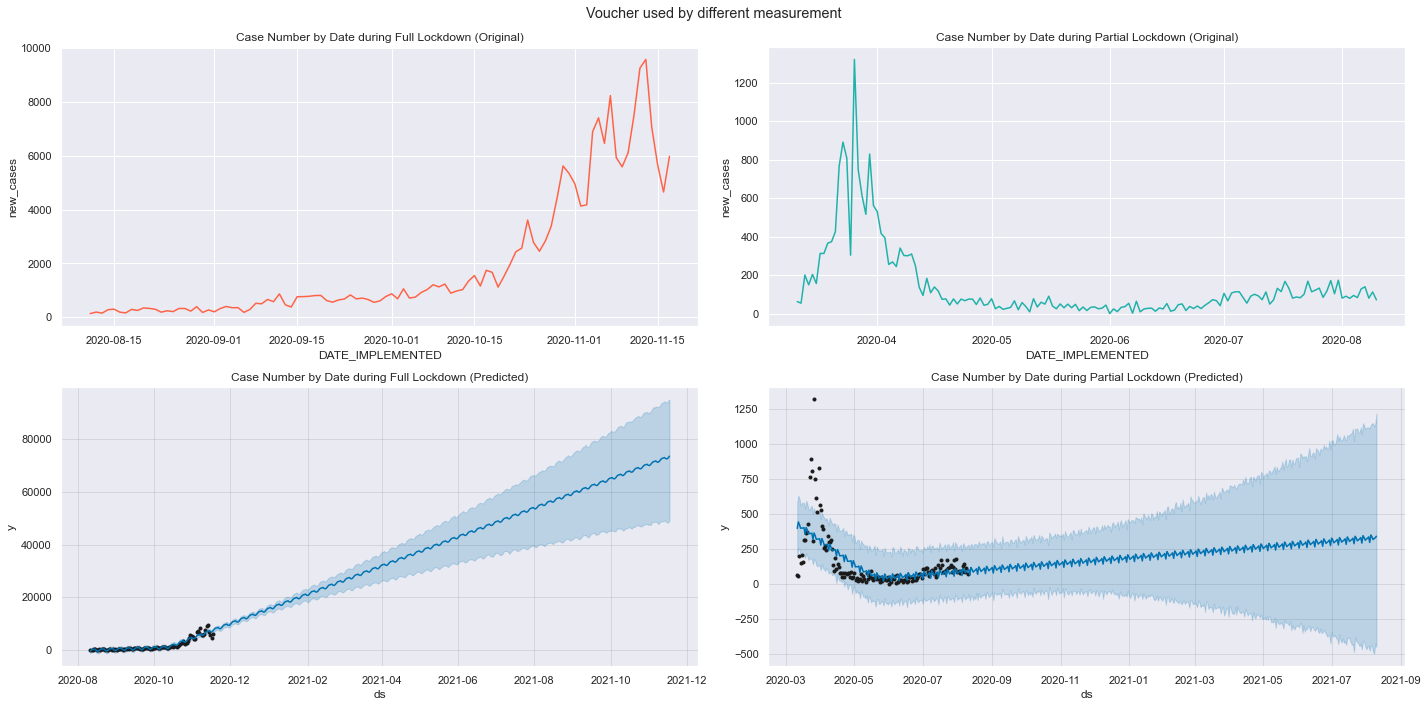

In [92]:
forecast('Austria')

* The lineplot for predicted data for both full lockdown and partial lockdown shows that new cases might increase in the next 365 days. However, new cases during full lockdown might have growth rate higher than partial lockdown. For partial lockdown measurement, new cases seems to remain stable. 
* R-square of full lockdown measurement (0.92) is good, but MSE is large. The model may be overfitting.
* R-square of partial lockdown measurement (0.45) show a low correlation.

**Iraq**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-05-26 00:00:00 and 2020-06-02 00:00:00


(24, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:n_changepoints greater than number of observations. Using 17.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-26 00:00:00 and 2020-11-02 00:00:00


R-square score (full lockdown) is: 0.7002183553186154
MSE value (full lockdown) is: 10571.611815706854
MAE value (full lockdown) is: 79.13954192046312
(217, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.9493323645522576
MSE value (partial lockdown) is: 138656.76470138683
MAE value (partial lockdown) is: 277.8695560358189


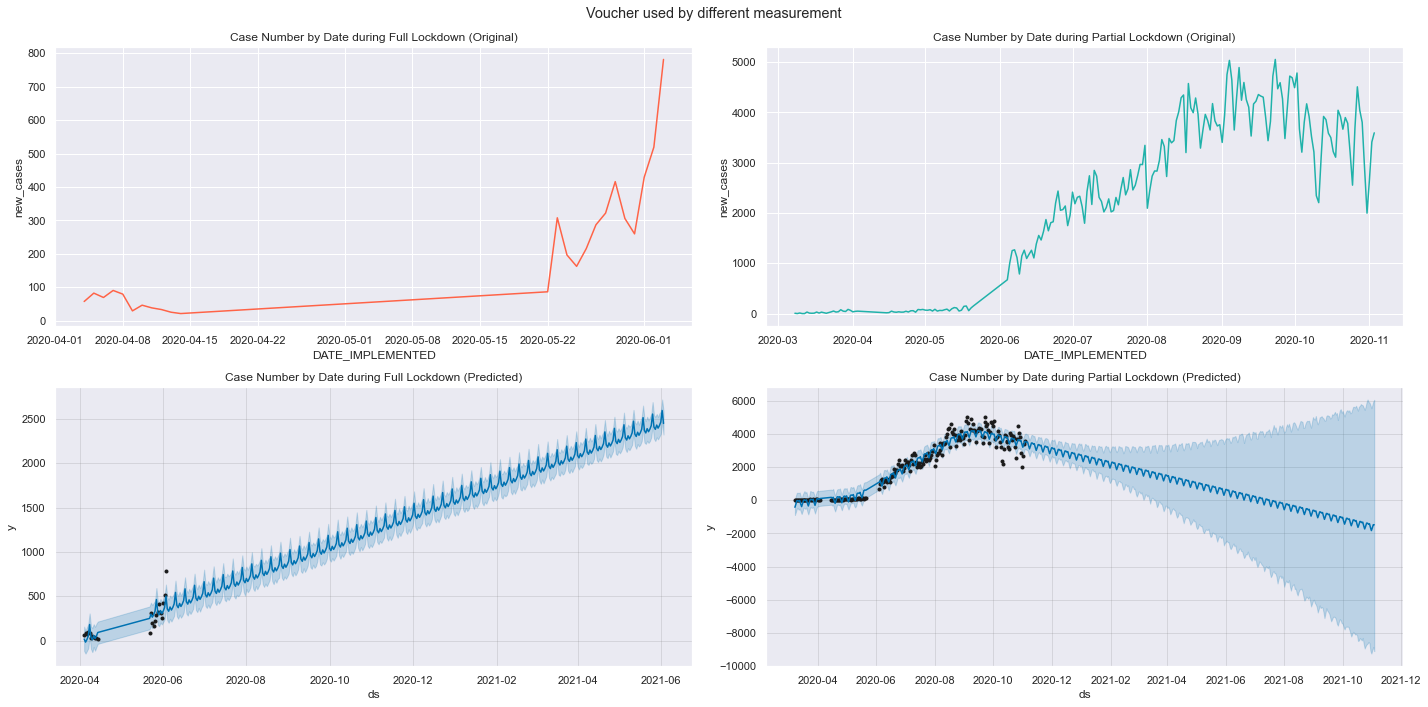

In [93]:
forecast('Iraq')

* The lineplot for predicted data shows that new cases might increase significantly in the next 365 days for full lockdown measurement, and for partial lockdown new cases might decrease. 
* R-square of full lockdown measurement (0.7) show quite strong correlation, but MSE is large. The model may be overfitting.
* R-square of partial lockdown measurement (0.94) show a strong correlation, but MSE is large. The model may be overfitting.

**Israel**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-09 00:00:00 and 2020-10-16 00:00:00


(68, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Making 8 forecasts with cutoffs between 2020-11-20 00:00:00 and 2020-11-27 00:00:00


R-square score (full lockdown) is: 0.32569108776194566
MSE value (full lockdown) is: 2397855.6409423095
MAE value (full lockdown) is: 1075.4875380070957
(189, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.34731971847361276
MSE value (partial lockdown) is: 822862.9564182252
MAE value (partial lockdown) is: 525.4059271200501


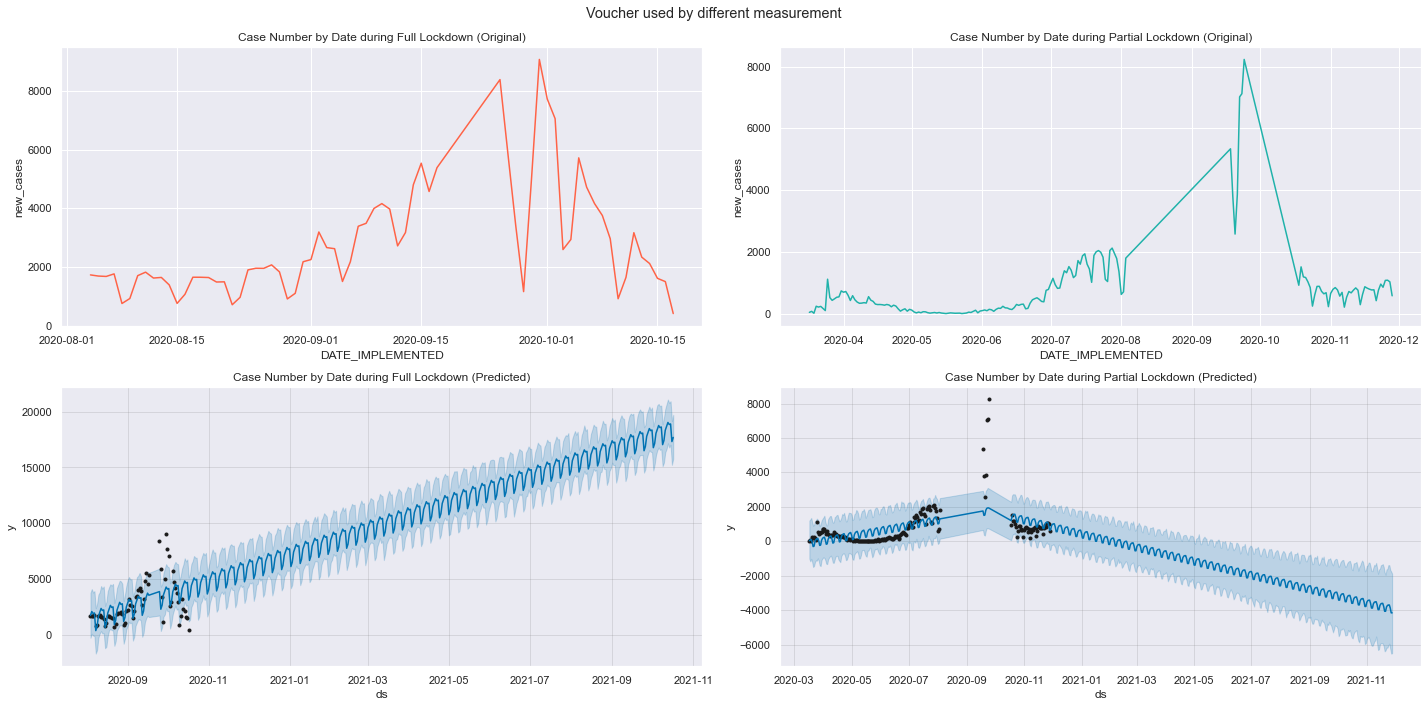

In [94]:
forecast('Israel')

* The lineplot for predicted data shows that new cases might increase significantly in the next 365 days for full lockdown measurement, and for partial lockdown new cases might decrease. 
* R-square of full lockdown measurement (0.33) show low correlation and MSE is large.
* R-square of partial lockdown measurement (0.35) show low correlation and MSE is large.

**Italy**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-27 00:00:00 and 2020-11-03 00:00:00


(123, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Making 8 forecasts with cutoffs between 2020-09-25 00:00:00 and 2020-10-02 00:00:00


R-square score (full lockdown) is: 0.7370515160749986
MSE value (full lockdown) is: 16303050.472894229
MAE value (full lockdown) is: 2413.380029870784
(107, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.9579616433368661
MSE value (partial lockdown) is: 65705.78104922733
MAE value (partial lockdown) is: 193.42564708305224


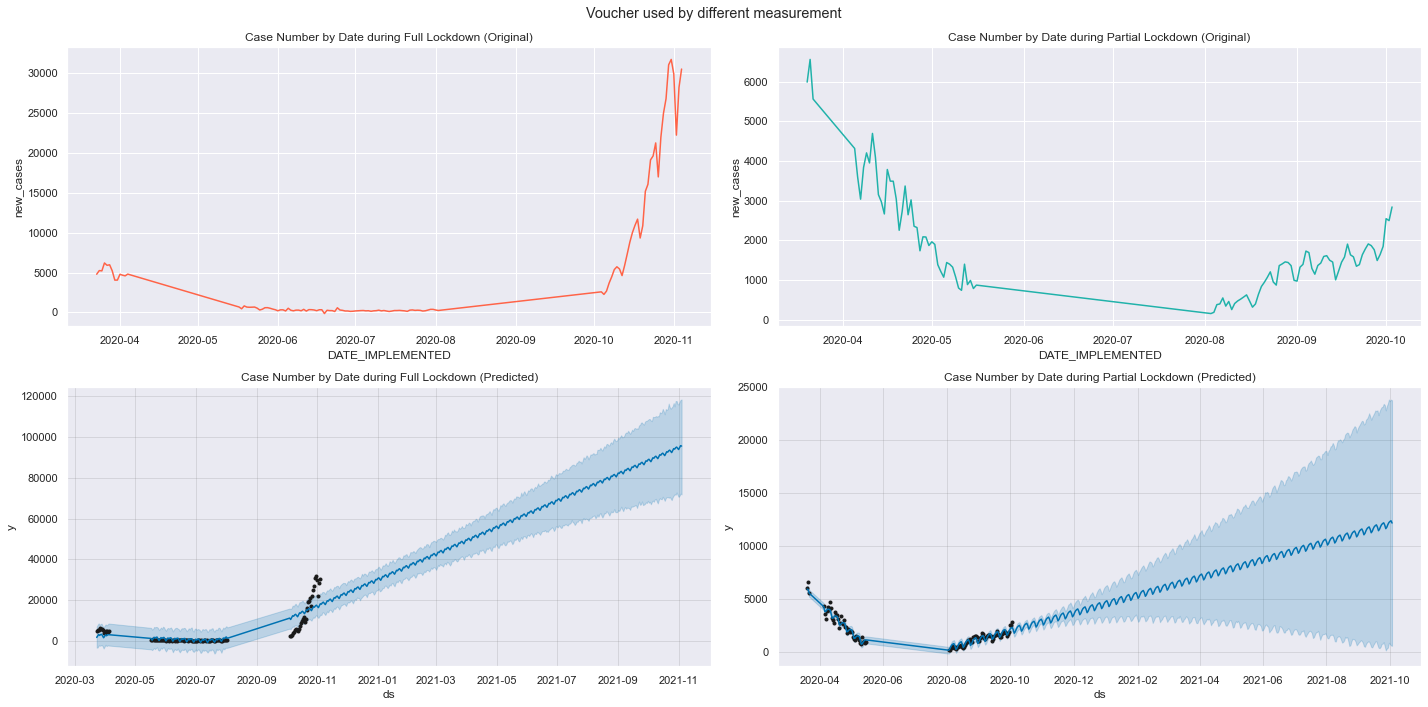

In [95]:
forecast('Italy')

* The lineplot for predicted data for both full lockdown and partial lockdown shows that new cases might increase in the next 365 days. However, new cases during full lockdown might have growth rate higher than partial lockdown.
* R-square of full lockdown measurement (0.74) show quite strong correlation, but MSE is large. The model may be overfitting.
* R-square of partial lockdown measurement (0.96) show a strong correlation, but MSE is large. The model may be overfitting.

**Jordan**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-12 00:00:00 and 2020-10-19 00:00:00


(55, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Making 8 forecasts with cutoffs between 2020-08-26 00:00:00 and 2020-09-02 00:00:00


R-square score (full lockdown) is: 0.3764528111438672
MSE value (full lockdown) is: 304244.7154053619
MAE value (full lockdown) is: 470.4827935399356
(162, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.38000369910755094
MSE value (partial lockdown) is: 205.6804890424606
MAE value (partial lockdown) is: 8.759853612360098


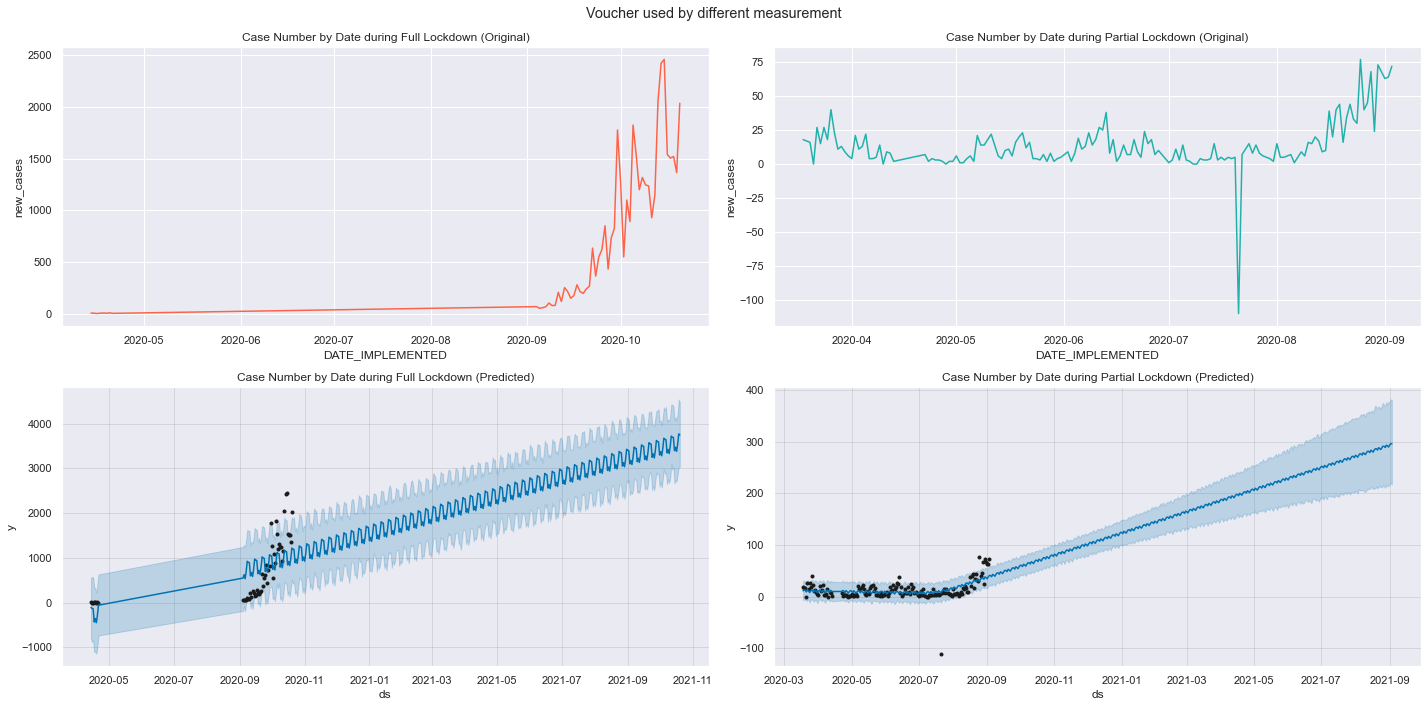

In [96]:
forecast('Jordan')

* The lineplot for predicted data for both full lockdown and partial lockdown shows that new cases might increase in the next 365 days. However, new cases during full lockdown and partial lockdown might have the same growth rate. 
* R-square of full lockdown measurement (0.38) show a low correlation and MSE is large.
* R-square of partial lockdown measurement (0.38) show a low correlation and MSE is large.

**Kazakhstan**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-07-08 00:00:00 and 2020-07-15 00:00:00


(72, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-29 00:00:00 and 2020-11-05 00:00:00


R-square score (full lockdown) is: 0.15181561096002316
MSE value (full lockdown) is: 4378259.0934913345
MAE value (full lockdown) is: 879.7950693120513
(161, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.396495886997681
MSE value (partial lockdown) is: 383268.5584182584
MAE value (partial lockdown) is: 384.6525270235889


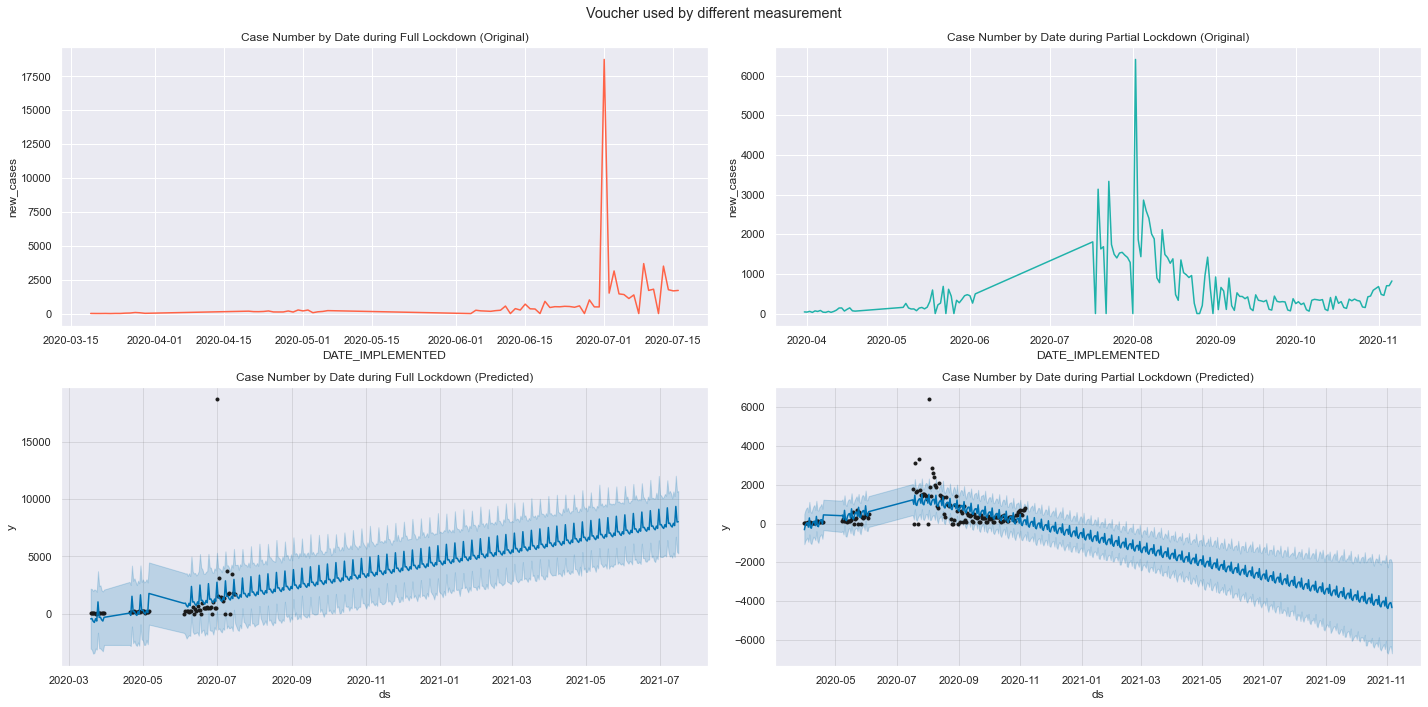

In [97]:
forecast('Kazakhstan')

* The lineplot for predicted data shows that new cases might increase significantly in the next 365 days for full lockdown measurement, and for partial lockdown new cases might decrease.
* R-square of full lockdown measurement (0.15) show a low correlation and MSE is large. This model may not valid.
* R-square of partial lockdown measurement (0.4) show a low correlation and MSE is large.

**Malaysia**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 8 forecasts with cutoffs between 2020-09-25 00:00:00 and 2020-10-02 00:00:00


(173, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Making 1 forecasts with cutoffs between 2020-10-03 00:00:00 and 2020-10-03 00:00:00


R-square score (full lockdown) is: 0.2205945352512133
MSE value (full lockdown) is: 3202.1907243353617
MAE value (full lockdown) is: 41.359027190179354
(82, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.08943378464110008
MSE value (partial lockdown) is: 3119.8891116179266
MAE value (partial lockdown) is: 38.72670007283889


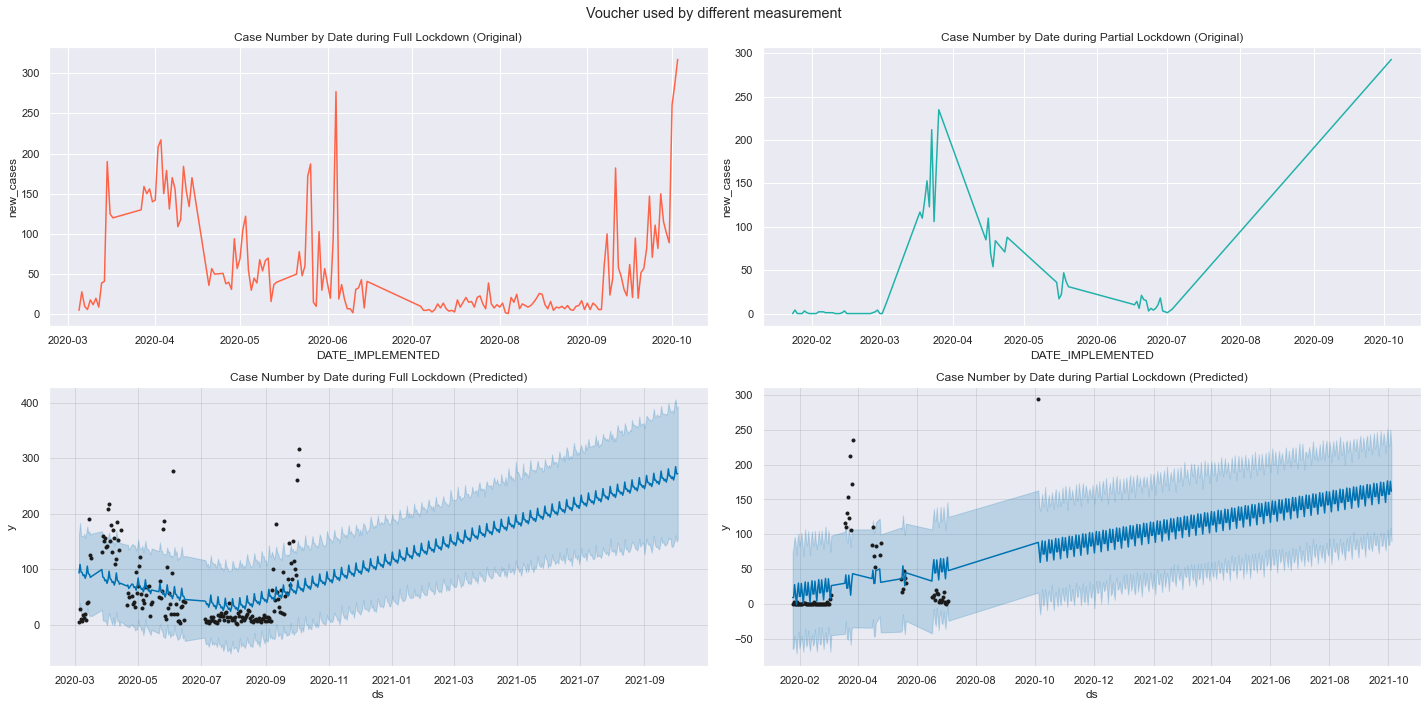

In [98]:
forecast('Malaysia')

* The lineplot for predicted data for both full lockdown and partial lockdown shows that new cases might increase in the next 365 days. New cases during full lockdown and partial lockdown seems to have the same growth rate. 
* R-square of full lockdown measurement (0.22) show a low correlation, MSE is large. This model may not valid.
* R-square of partial lockdown measurement (0.08) show that there is no correlation. This model may not valid.

**Nepal**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-11-04 00:00:00 and 2020-11-04 00:00:00


(40, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-27 00:00:00 and 2020-11-03 00:00:00


R-square score (full lockdown) is: 0.9976745176811641
MSE value (full lockdown) is: 528.7482504474209
MAE value (full lockdown) is: 15.975405759268426
(246, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.8219894036841034
MSE value (partial lockdown) is: 210469.21404835093
MAE value (partial lockdown) is: 245.8324799421636


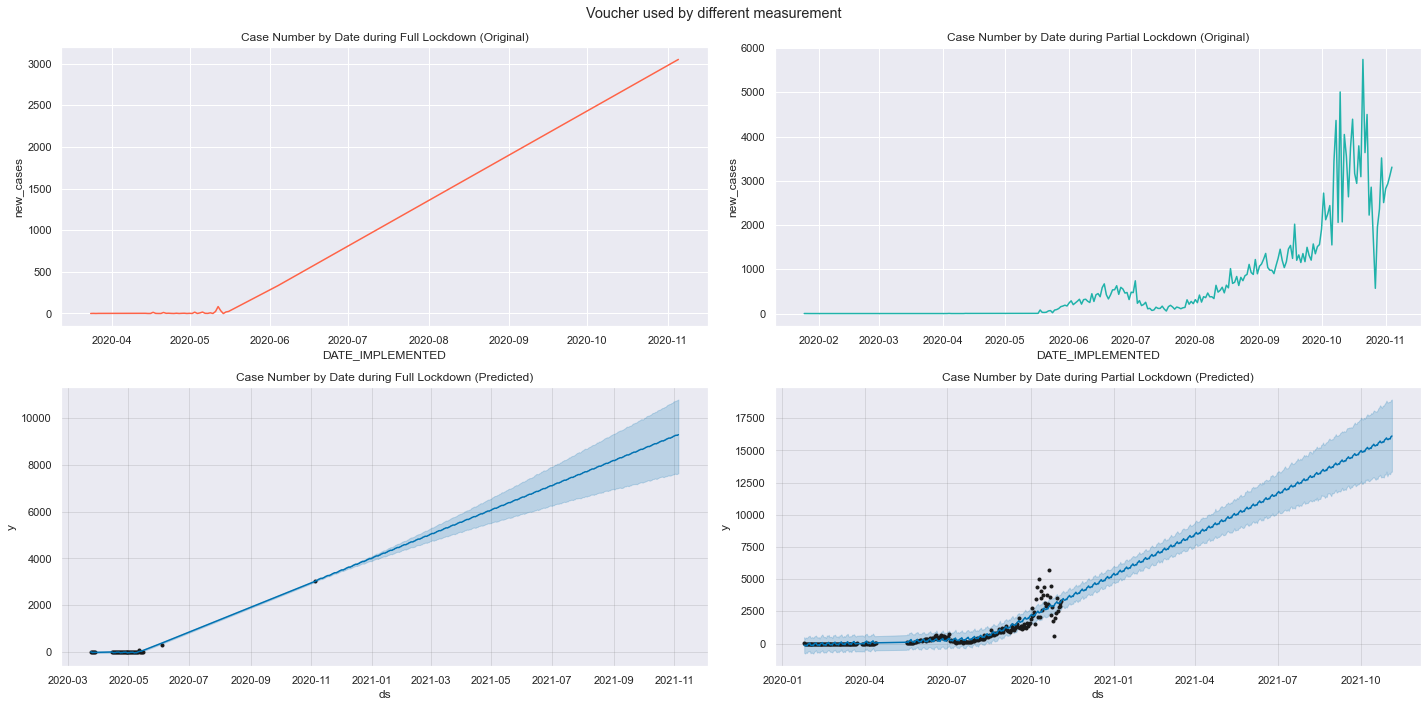

In [99]:
forecast('Nepal')

* The lineplot for predicted data for both full lockdown and partial lockdown shows that new cases might increase in the next 365 days. New cases during full lockdown and partial lockdown seems to have the same growth rate. 
* R-square of full lockdown measurement (0.99) show significantly high correlation and MSE is large. This model may be overfitting.
* R-square of partial lockdown measurement (0.82) show that show a high correlation and MSE is large. 

**Philippines**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-03 00:00:00 and 2020-12-03 00:00:00


(44, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Making 7 forecasts with cutoffs between 2020-12-01 00:00:00 and 2020-12-08 00:00:00


R-square score (full lockdown) is: 0.7603483613954594
MSE value (full lockdown) is: 230196.19360150673
MAE value (full lockdown) is: 382.93848329729315
(271, 2)


  0%|          | 0/7 [00:00<?, ?it/s]

R-square score (partial lockdown) is: 0.8029087737531999
MSE value (partial lockdown) is: 410166.4007266099
MAE value (partial lockdown) is: 410.95869584338925


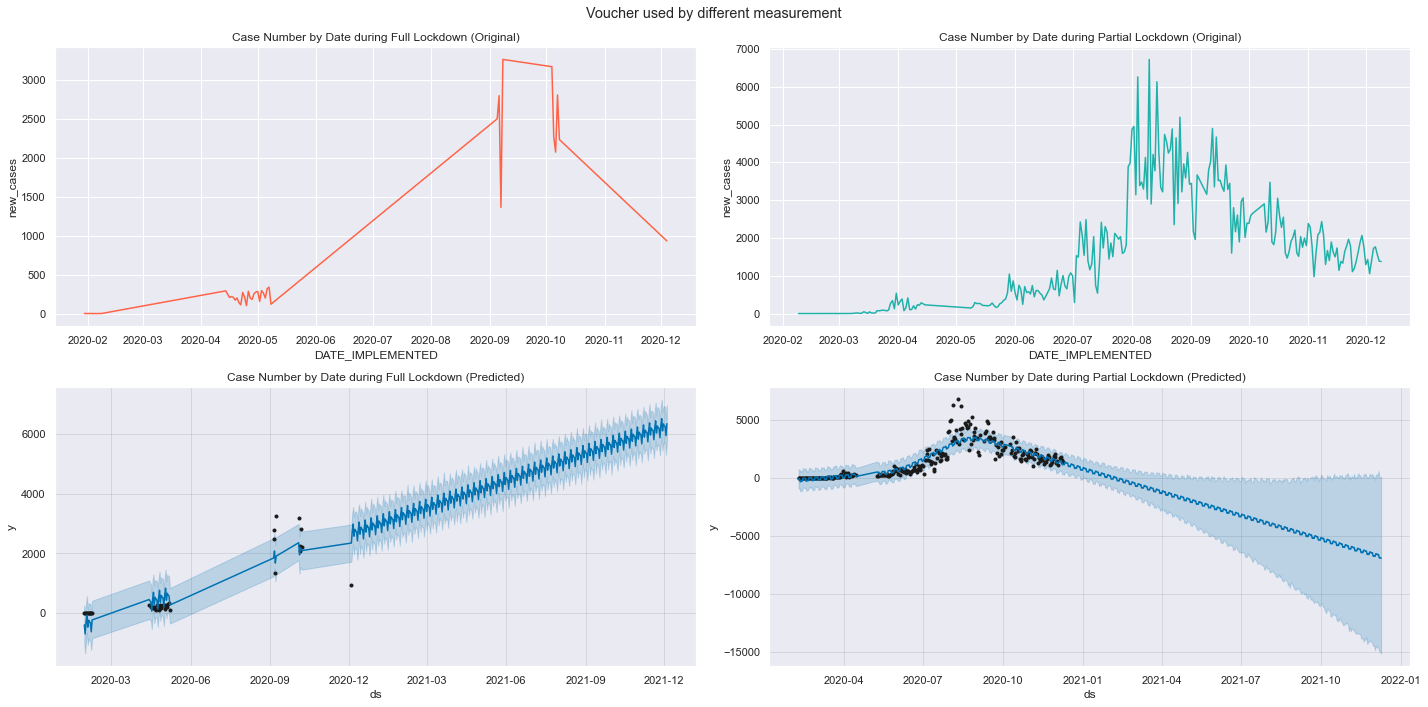

In [100]:
forecast('Philippines')

* The lineplot for predicted data shows that new cases might increase significantly in the next 365 days for full lockdown measurement, and for partial lockdown new cases might decrease.
* R-square of full lockdown measurement (0.76) show medium-high correlation and MSE is large. 
* R-square of partial lockdown measurement (0.8) show a high correlation and MSE is large. 

**Spain**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-11-04 00:00:00 and 2020-11-04 00:00:00


(168, 2)


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Making 8 forecasts with cutoffs between 2020-10-27 00:00:00 and 2020-11-03 00:00:00


R-square score (full lockdown) is: 0.2557303693556875
MSE value (full lockdown) is: 5740550.430809945
MAE value (full lockdown) is: 1518.0752680889723
(111, 2)


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


R-square score (partial lockdown) is: 0.7289985638478306
MSE value (partial lockdown) is: 29477786.531585284
MAE value (partial lockdown) is: 3653.9971397096615


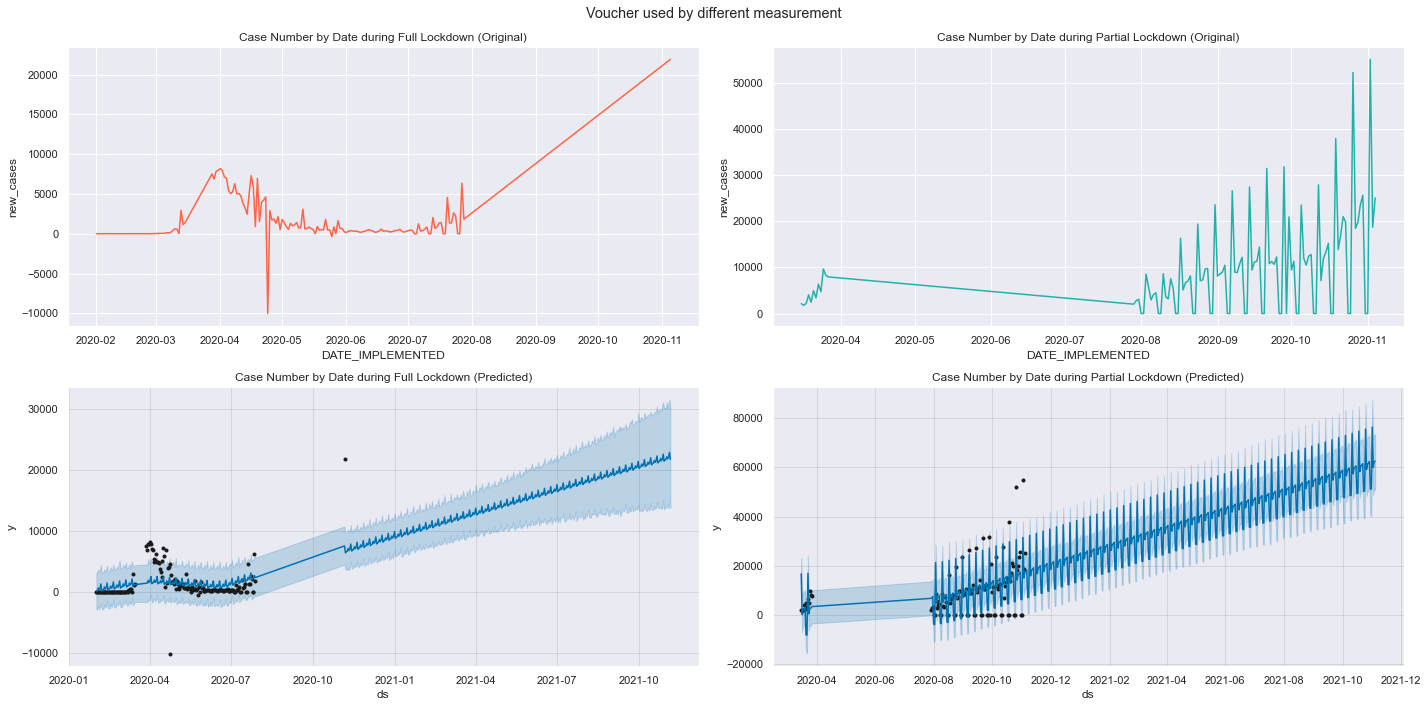

In [101]:
forecast('Spain')

* The lineplot for predicted data for both full lockdown and partial lockdown shows that new cases might increase in the next 365 days. New cases during full lockdown and partial lockdown seems to have the same growth rate. 
* R-square of full lockdown measurement (0.26) show a low correlation and MSE is large. This model may not valid.
* R-square of partial lockdown measurement (0.73) show that show medium-high correlation and MSE is large. 

### Conclusion
* The Prophet model in all 10 countries shows that for full lockdown measurement, the daily new cases might increase and the growth rate might be different for different countries. For partial lockdown measurement, the daily new cases might decrease in 4 countries (Iraq, Israel, Kazakhstan and Philippines), while the other 6 countries might increase. 
* The Prophet model shows that different countries might have different case growth rate. Full lockdown seems to not effective to reduce the COVID-19 cases. Partial lockdown could somehow reduce the new cases and might be more effective than full lockdown measurement. 

## Hierarchical Clustering

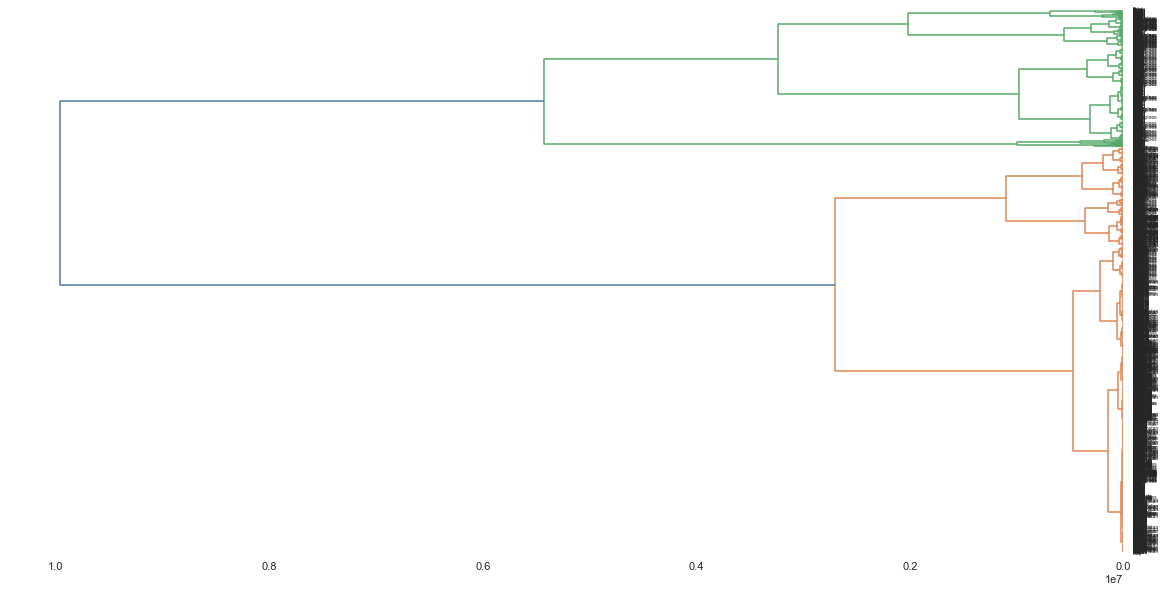

In [102]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
# Dropping non-numeric columns from the original datafram
ld_tc_trial = ld_tc_trial.drop(columns=['DATE_IMPLEMENTED','REGION_x'])
ld_tc_trial_hc = ld_tc_trial.set_index('COUNTRY')
# HC model
dist = pdist(ld_tc_trial_hc, 'euclidean')
linkage_matrix = linkage(dist, method = 'ward')
plt.figure(figsize=(20,10))
dendrogram(linkage_matrix,labels=list(ld_tc_trial.COUNTRY),orientation='left')
plt.show()